# Installing Libs

# Importing Libs

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from datasets import load_dataset
import openai
from huggingface_hub import login
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV

from transformers import Trainer
from transformers import TrainingArguments
from sentence_transformers import SentenceTransformer
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from transformers import BertTokenizer, BertModel
import nltk
import torch
from transformers import BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm.auto import tqdm

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
def plot_training_history(trainer):
    steps = []
    train_losses = []
    eval_steps = []
    eval_losses = []
    eval_acc_steps = []
    eval_accs = []

    for step in trainer.state.log_history:
        if 'loss' in step and 'step' in step:
            steps.append(step['step'])
            train_losses.append(step['loss'])
        if 'eval_loss' in step and 'step' in step:
            eval_steps.append(step['step'])
            eval_losses.append(step['eval_loss'])
        if 'eval_Accuracy' in step and 'step' in step:
            eval_acc_steps.append(step['step'])
            eval_accs.append(step['eval_Accuracy'])

    plt.figure(figsize=(12, 7))
    ax = plt.gca()
    sns.lineplot(x=steps, y=train_losses, label='Training Loss', color='red', ax=ax)
    sns.lineplot(x=eval_steps, y=eval_losses, label='Validation Loss', color='blue', ax=ax)
    ax.set_ylabel('Loss')
    if eval_accs:
        ax2 = ax.twinx()
        sns.lineplot(x=eval_acc_steps, y=eval_accs, label='Validation Accuracy', color='green', ax=ax2)
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='lower right')
    ax.legend(loc='upper right')
    plt.title('Training/Validation Loss and Accuracy over Steps')
    plt.xlabel('Step')
    plt.show()

# Importing Data

In [ ]:
login(token="TOKEN_HERE")
dataset = load_dataset('Ktzoras/shipping_news_articles_summary_emb', split = 'train')
df = pd.DataFrame(dataset)
type(df.date.iloc[0])
del dataset


In [114]:
dataset = load_dataset('Ktzoras/shipping_llm_results_3k_sample', split = 'train')
training = pd.DataFrame(dataset)
del dataset

# Preproc

In [115]:
df.columns

Index(['link', 'date', 'title', 'content', 'led_summ', 'bart_summ',
       'impact_idrbfe', 'sen_emb', 'sen_emb_mean', 'sen_emb_max',
       'sen_emb_mix', 'sen_emb_sum', 'sen_emb_concat', 'sen_emb_mix2'],
      dtype='object')

In [116]:
training.columns

Index(['link', 'date', 'title', 'content', 'vectors_L6_v2', 'vectors_distil',
       'classes_distil', 'Scale_fe', 'Type of Vessel_fe', 'Vessel Size_fe',
       'Sea Route_fe', 'Duration of Positive Impact_fe', 'Impact_fe',
       'Hire Rate Impact_fe', 'Scale_rag', 'Type of Vessel_rag',
       'Vessel Size_rag', 'Sea Route_rag', 'Duration of Positive Impact_rag',
       'Impact_rag', 'Hire Rate Impact_rag', 'Scale_idfe',
       'Type of Vessel_idfe', 'Vessel Size_idfe', 'Sea Route_idfe',
       'Duration of Positive Impact_idfe', 'Impact_idfe',
       'Hire Rate Impact_idfe', 'Scale_idrbfe', 'Type of Vessel_idrbfe',
       'Vessel Size_idrbfe', 'Sea Route_idrbfe',
       'Duration of Positive Impact_idrbfe', 'Impact_idrbfe',
       'Hire Rate Impact_idrbfe', 'Hire rate impact_rag', '__index_level_0__'],
      dtype='object')

In [117]:
training.Impact_idrbfe.value_counts()

Impact_idrbfe
Positive    1506
None         919
Negative     574
Mixed          1
Name: count, dtype: int64

In [118]:
training.replace('Mixed', 'None', inplace=True)

In [119]:
training = pd.concat([training[:2000], training[2000:].iloc[::-1]], axis=0)

In [131]:
training = training[:1000]

In [133]:
train_x, test_x, train_y, test_y = train_test_split(df['bart_summ'][:1000], training['Impact_idrbfe'], test_size=0.2, random_state=42, stratify = training['Impact_idrbfe'])
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((800,), (200,), (800,), (200,))

In [121]:
train_y.value_counts()

Impact_idrbfe
Positive    1205
None         736
Negative     459
Name: count, dtype: int64

In [122]:
train_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0).value_counts()

Impact_idrbfe
2    1205
1     736
0     459
Name: count, dtype: int64

In [123]:
train_y = train_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0)
test_y = test_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0)

# Classification

## Embendings

In [124]:
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = BertModel.from_pretrained("google-bert/bert-base-uncased")
nltk.download('punkt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)   

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tzora\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [125]:
device

device(type='cuda')

### Tokenize per sentence

In [126]:
def get_article_embeddings_sentence(article, tokenizer, model, device, max_length=512):
    # Split article into sentences
    sentences = nltk.sent_tokenize(article)
    sent_embeddings = []
    for sent in sentences:
        # Tokenize and encode each sentence
        tokens = tokenizer(
            sent,
            padding='max_length',
            # truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        tokens = {k: v.to(device) for k, v in tokens.items()}
        with torch.no_grad(): # Disable gradient calculation
            outputs = model(
                input_ids=tokens['input_ids'],
                attention_mask=tokens['attention_mask']
            )
            # Get [CLS] embedding
            cls_emb = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()
            sent_embeddings.append(cls_emb)
    return sent_embeddings

def get_article_embeddings_agg(sent_embeddings, model, agg='mean', max_sentences=10):
    hidden_size = model.config.hidden_size
    # Handle empty input
    if len(sent_embeddings) == 0:
        if agg == 'concat':
            return np.zeros(hidden_size * max_sentences)
        elif agg == 'mix2':
            return np.zeros(hidden_size * 4)
        else:
            return np.zeros(hidden_size)
    # Ensure sent_embeddings is a 2D array
    sent_embeddings = np.array(sent_embeddings)
    if sent_embeddings.ndim == 1:
        sent_embeddings = sent_embeddings.reshape(1, -1)
    if agg == 'mean':
        return sent_embeddings.mean(axis=0)
    elif agg == 'max':
        return sent_embeddings.max(axis=0)
    elif agg == 'mix':
        return (sent_embeddings.mean(axis=0) + sent_embeddings.max(axis=0)) / 2
    elif agg == 'sum':
        return sent_embeddings.sum(axis=0)
    elif agg == 'concat':
        flat = sent_embeddings.flatten()
        target_len = hidden_size * max_sentences
        if flat.shape[0] < target_len:
            pad_width = target_len - flat.shape[0]
            flat = np.pad(flat, (0, pad_width), mode='constant')
        else:
            flat = flat[:target_len]
        return flat
    elif agg == 'mix2':
        # Mix mean, max, min, sum
        return np.concatenate([
            sent_embeddings.mean(axis=0).reshape(-1),
            sent_embeddings.max(axis=0).reshape(-1),
            sent_embeddings.min(axis=0).reshape(-1),
            sent_embeddings.sum(axis=0).reshape(-1)
        ])
    else:
        raise ValueError("agg must be one of 'mean', 'max', 'mix', 'sum', 'concat', 'mix2'")

In [127]:
# def get_article_embedding_sentence(article, tokenizer, model, device, max_length=512, agg='mean'):
#     # Split article into sentences
#     sentences = nltk.sent_tokenize(article)
#     sent_embeddings = []
#     for sent in sentences:
#         # Tokenize and encode each sentence
#         tokens = tokenizer(
#             sent,
#             padding='max_length',
#             # truncation=True,
#             max_length=max_length,
#             return_tensors='pt'
#         )
#         tokens = {k: v.to(device) for k, v in tokens.items()}
#         with torch.no_grad(): # Disable gradient calculation
#             outputs = model(
#                 input_ids=tokens['input_ids'],
#                 attention_mask=tokens['attention_mask']
#             )
#             # Get [CLS] embedding
#             cls_emb = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()
#             sent_embeddings.append(cls_emb)
#     if len(sent_embeddings) == 0:
#         # If article is empty, return zeros
#         return np.zeros(model.config.hidden_size)
#     sent_embeddings = np.stack(sent_embeddings)
#     if agg == 'mean':
#         return sent_embeddings.mean(axis=0)
#     elif agg == 'max':
#         return sent_embeddings.max(axis=0)
#     elif agg == 'mix':
#         # Mix mean and max
#         return (sent_embeddings.mean(axis=0) + sent_embeddings.max(axis=0)) / 2
#     elif agg == 'sum':
#         return sent_embeddings.sum(axis=0)
#     elif agg == 'concat':
#         # Concatenate mean and max
#         return np.concatenate((sent_embeddings.mean(axis=0), sent_embeddings.max(axis=0)))
#     elif agg == 'mix2':
#         # Mix mean and max with different weights
#         return (sent_embeddings.mean(axis=0) * 0.7 + sent_embeddings.max(axis=0) * 0.3)
#     else:
#         raise ValueError("agg must be 'mean' or 'max'")
    
def get_article_embeddings(articles, tokenizer, model, device, max_length=512):
    embeddings = []
    for article in tqdm(articles):
        tokens = tokenizer(
            article,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        tokens = {k: v.to(device) for k, v in tokens.items()}
        with torch.no_grad():
            outputs = model(
                input_ids=tokens['input_ids'],
                attention_mask=tokens['attention_mask']
            )
            # Get [CLS] embedding for the whole article
            cls_emb = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()
            embeddings.append(cls_emb)
    return np.array(embeddings)

In [136]:
embeddings_train = []
for article in train_x:
    emb = get_article_embeddings_sentence(article, tokenizer, bert_model, device)
    embeddings_train.append(emb)

embeddings_test = []
for article in test_x:
    emb = get_article_embeddings_sentence(article, tokenizer, bert_model, device)
    embeddings_test.append(emb)

In [137]:
train_x_sen_mean = []
train_x_sen_max = []
train_x_sen_mix = []
train_x_sen_sum = []
train_x_sen_concat = []
train_x_sen_mix2 = []
for emb in embeddings_train:
    train_x_sen_mean.append(get_article_embeddings_agg(emb, bert_model, agg='mean'))
    train_x_sen_max.append(get_article_embeddings_agg(emb, bert_model, agg='max'))
    train_x_sen_mix.append(get_article_embeddings_agg(emb, bert_model, agg='mix'))
    train_x_sen_sum.append(get_article_embeddings_agg(emb, bert_model, agg='sum'))
    train_x_sen_concat.append(get_article_embeddings_agg(emb, bert_model, agg='concat'))
    train_x_sen_mix2.append(get_article_embeddings_agg(emb, bert_model, agg='mix2'))


test_x_sen_mean = []
test_x_sen_max = []
test_x_sen_mix = []
test_x_sen_sum = []
test_x_sen_concat = []
test_x_sen_mix2 = []
for emb in embeddings_test:
    test_x_sen_mean.append(get_article_embeddings_agg(emb, bert_model, agg='mean'))
    test_x_sen_max.append(get_article_embeddings_agg(emb, bert_model, agg='max'))
    test_x_sen_mix.append(get_article_embeddings_agg(emb, bert_model, agg='mix'))
    test_x_sen_sum.append(get_article_embeddings_agg(emb, bert_model, agg='sum'))
    test_x_sen_concat.append(get_article_embeddings_agg(emb, bert_model, agg='concat'))
    test_x_sen_mix2.append(get_article_embeddings_agg(emb, bert_model, agg='mix2'))

### Tokenize Full

In [139]:
train_x_full = get_article_embeddings(train_x, tokenizer, bert_model, device)
test_x_full = get_article_embeddings(test_x, tokenizer, bert_model, device)

100%|██████████| 200/200 [00:05<00:00, 37.34it/s]


## Models

### Simple ML

In [128]:
logreg = LogisticRegression()
svc = SVC(kernel='linear')
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
grb = GradientBoostingClassifier()

vt = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('svc', svc),
    ('rf', rf),
    ('dt', dt),
    ('knn', knn)
], voting='soft')
bag = BaggingClassifier(n_estimators=10, random_state=42)
hist_grb = HistGradientBoostingClassifier()
stack = StackingClassifier(estimators=[
    ('logreg', logreg),
    ('svc', svc),
    ('rf', rf),
    ('dt', dt),
    ('knn', knn)
], final_estimator=LogisticRegression())
ada = AdaBoostClassifier(n_estimators=50, random_state=42)
extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=42)

models = [logreg, svc, rf, dt, knn]

results = []
def train_and_evaluate_model(models, train_x, train_y, test_x, test_y, results, data, optimize = False):
    if torch.is_tensor(train_y):
        train_y = train_y.cpu().numpy()
    if torch.is_tensor(test_y):
        test_y = test_y.cpu().numpy()
    if torch.is_tensor(train_x):
        train_x = train_x.cpu().numpy()
    if torch.is_tensor(test_x):
        test_x = test_x.cpu().numpy()
    if not optimize:
            # Before your model training loop, add:

        for model in models:
            model.fit(train_x, train_y)
            pred = model.predict(test_x)
            acc = accuracy_score(test_y, pred)
            f1 = f1_score(test_y, pred, average='weighted')
            precision = precision_score(test_y, pred, average='weighted')
            recall = recall_score(test_y, pred, average='weighted')
            results.append((data, model.__class__.__name__, optimize, acc, f1, precision, recall))
            print(f"Model: {model.__class__.__name__}")
            print(f"Data type: {data}")
            print(f"Accuracy: {acc:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print("\n" + "="*50 + "\n")

            results_df = pd.DataFrame(results, columns=['Data', 'Model', 'Optimized', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
            results_df = results_df.sort_values(by='F1 Score', ascending=False)
            # results = pd.concat([pd.DataFrame(results), results_df], axis = 0)


    else:


        param_grids = {
            'LogisticRegression': {
                'C': [0.001, 0.01, 0.1, 1, 10, 100]
            },
            'SVC': {
                'C': [0.01, 0.1, 1, 10, 100],
                'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                'gamma': ['scale', 'auto']  # add if using RBF/poly/sigmoid kernels
            },
            'RandomForestClassifier': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [None, 10, 20, 30, 50],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'DecisionTreeClassifier': {
                'max_depth': [None, 5, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'KNeighborsClassifier': {
                'n_neighbors': list(range(1, 21)),  # from 1 to 20
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski']
            },
            'GradientBoostingClassifier': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'VotingClassifier': {
                'voting': ['soft', 'hard'],
                'weights': [[1, 1, 1, 1, 1], [2, 1, 1, 1, 1], [1, 2, 1, 1, 1]]  # Example weights
            },
            'BaggingClassifier': {
                'n_estimators': [10, 50, 100],
                'max_samples': [0.5, 0.75, 1.0],
                'max_features': [0.5, 0.75, 1.0]
            },
            'HistGradientBoostingClassifier': {
                'max_iter': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'min_samples_leaf': [1, 2, 4]
            },
            'StackingClassifier': {
                'final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
                'cv': [3, 5]
            },
            'AdaBoostClassifier': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2]
            },
            'ExtraTreesClassifier': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30, 50],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        }


        for model in models:
            model_name = model.__class__.__name__
            param_grid = param_grids.get(model_name, {})

            grid = GridSearchCV(model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
            grid.fit(train_x, train_y)
            best_model = grid.best_estimator_
            pred = best_model.predict(test_x)
            acc = accuracy_score(test_y, pred)
            f1 = f1_score(test_y, pred, average='weighted')
            precision = precision_score(test_y, pred, average='weighted')
            recall = recall_score(test_y, pred, average='weighted')
            results.append((data, model_name, True, acc, f1, precision, recall))
            print(f"Model: {model_name} (Optimized)")
            print(f"Data type: {data}")
            print(f"Accuracy: {acc:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print("\n" + "="*50 + "\n")

        results_df = pd.DataFrame(results, columns=['Data', 'Model', 'Optimized', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
        results_df = results_df.sort_values(by='F1 Score', ascending=False)

In [134]:
train_y.value_counts()

Impact_idrbfe
None        374
Positive    285
Negative    141
Name: count, dtype: int64

In [140]:
train_and_evaluate_model(models, train_x_sen_mean, train_y, test_x_sen_mean, test_y, results, 'mean')
train_and_evaluate_model(models, train_x_sen_max, train_y, test_x_sen_max, test_y, results, 'max')
train_and_evaluate_model(models, train_x_full, train_y, test_x_full, test_y, results, 'full')
train_and_evaluate_model(models, train_x_sen_mix, train_y, test_x_sen_mix, test_y, results, 'mix')
train_and_evaluate_model(models, train_x_sen_sum, train_y, test_x_sen_sum, test_y, results, 'sum')
train_and_evaluate_model(models, train_x_sen_concat, train_y, test_x_sen_concat, test_y, results, 'concat')
train_and_evaluate_model(models, train_x_sen_mix2, train_y, test_x_sen_mix2, test_y, results, 'mix2')

Model: LogisticRegression
Data type: mean
Accuracy: 0.6200
F1 Score: 0.6225
Precision: 0.6311
Recall: 0.6200


Model: SVC
Data type: mean
Accuracy: 0.5850
F1 Score: 0.5857
Precision: 0.5872
Recall: 0.5850


Model: RandomForestClassifier
Data type: mean
Accuracy: 0.6300
F1 Score: 0.6284
Precision: 0.6373
Recall: 0.6300


Model: DecisionTreeClassifier
Data type: mean
Accuracy: 0.5450
F1 Score: 0.5435
Precision: 0.5424
Recall: 0.5450


Model: KNeighborsClassifier
Data type: mean
Accuracy: 0.6650
F1 Score: 0.6662
Precision: 0.6822
Recall: 0.6650


Model: LogisticRegression
Data type: max
Accuracy: 0.6350
F1 Score: 0.6359
Precision: 0.6395
Recall: 0.6350


Model: SVC
Data type: max
Accuracy: 0.6200
F1 Score: 0.6208
Precision: 0.6237
Recall: 0.6200


Model: RandomForestClassifier
Data type: max
Accuracy: 0.6250
F1 Score: 0.6193
Precision: 0.6277
Recall: 0.6250


Model: DecisionTreeClassifier
Data type: max
Accuracy: 0.4900
F1 Score: 0.4899
Precision: 0.4907
Recall: 0.4900


Model: KNeighbors

In [87]:
train_and_evaluate_model(models, train_x_sen_mean, train_y, test_x_sen_mean, test_y, results, 'mean')
train_and_evaluate_model(models, train_x_sen_max, train_y, test_x_sen_max, test_y, results, 'max')
train_and_evaluate_model(models, train_x_full, train_y, test_x_full, test_y, results, 'full')
train_and_evaluate_model(models, train_x_sen_mix, train_y, test_x_sen_mix, test_y, results, 'mix')
train_and_evaluate_model(models, train_x_sen_sum, train_y, test_x_sen_sum, test_y, results, 'sum')
train_and_evaluate_model(models, train_x_sen_concat, train_y, test_x_sen_concat, test_y, results, 'concat')
train_and_evaluate_model(models, train_x_sen_mix2, train_y, test_x_sen_mix2, test_y, results, 'mix2')

Model: LogisticRegression
Data type: mean
Accuracy: 0.6850
F1 Score: 0.6852
Precision: 0.6862
Recall: 0.6850


Model: SVC
Data type: mean
Accuracy: 0.6450
F1 Score: 0.6447
Precision: 0.6456
Recall: 0.6450


Model: RandomForestClassifier
Data type: mean
Accuracy: 0.6050
F1 Score: 0.6026
Precision: 0.6025
Recall: 0.6050


Model: DecisionTreeClassifier
Data type: mean
Accuracy: 0.5200
F1 Score: 0.5205
Precision: 0.5215
Recall: 0.5200


Model: KNeighborsClassifier
Data type: mean
Accuracy: 0.6475
F1 Score: 0.6476
Precision: 0.6492
Recall: 0.6475


Model: LogisticRegression
Data type: max
Accuracy: 0.6325
F1 Score: 0.6331
Precision: 0.6350
Recall: 0.6325


Model: SVC
Data type: max
Accuracy: 0.6100
F1 Score: 0.6105
Precision: 0.6183
Recall: 0.6100


Model: RandomForestClassifier
Data type: max
Accuracy: 0.6200
F1 Score: 0.6144
Precision: 0.6155
Recall: 0.6200


Model: DecisionTreeClassifier
Data type: max
Accuracy: 0.4700
F1 Score: 0.4699
Precision: 0.4730
Recall: 0.4700


Model: KNeighbors

In [88]:
train_and_evaluate_model(models, train_x_sen_mean, train_y, test_x_sen_mean, test_y, results, 'mean', True)
train_and_evaluate_model(models, train_x_sen_max, train_y, test_x_sen_max, test_y, results, 'max', True)
train_and_evaluate_model(models, train_x_full, train_y, test_x_full, test_y, results, 'full', True)
train_and_evaluate_model(models, train_x_sen_mix, train_y, test_x_sen_mix, test_y, results, 'mix', True)
train_and_evaluate_model(models, train_x_sen_sum, train_y, test_x_sen_sum, test_y, results, 'sum', True)
train_and_evaluate_model(models, train_x_sen_concat, train_y, test_x_sen_concat, test_y, results, 'concat', True)
train_and_evaluate_model(models, train_x_sen_mix2, train_y, test_x_sen_mix2, test_y, results, 'mix2', True)

Model: LogisticRegression (Optimized)
Data type: mean
Accuracy: 0.6450
F1 Score: 0.6451
Precision: 0.6460
Recall: 0.6450


Model: SVC (Optimized)
Data type: mean
Accuracy: 0.7025
F1 Score: 0.7022
Precision: 0.7026
Recall: 0.7025


Model: RandomForestClassifier (Optimized)
Data type: mean
Accuracy: 0.6275
F1 Score: 0.6253
Precision: 0.6250
Recall: 0.6275


Model: DecisionTreeClassifier (Optimized)
Data type: mean
Accuracy: 0.5450
F1 Score: 0.5437
Precision: 0.5508
Recall: 0.5450


Model: KNeighborsClassifier (Optimized)
Data type: mean
Accuracy: 0.6575
F1 Score: 0.6585
Precision: 0.6705
Recall: 0.6575


Model: LogisticRegression (Optimized)
Data type: max
Accuracy: 0.6425
F1 Score: 0.6429
Precision: 0.6441
Recall: 0.6425


Model: SVC (Optimized)
Data type: max
Accuracy: 0.6725
F1 Score: 0.6726
Precision: 0.6727
Recall: 0.6725


Model: RandomForestClassifier (Optimized)
Data type: max
Accuracy: 0.6125
F1 Score: 0.6084
Precision: 0.6096
Recall: 0.6125


Model: DecisionTreeClassifier (Opti

### Deep

#### BERT default

In [66]:
device

device(type='cuda')

In [67]:
def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average = 'macro', zero_division = 0)
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [69]:
train_x, test_x, train_y, test_y = train_test_split(df['bart_summ'][:3000], training['Impact_idrbfe'], test_size=0.2, random_state=42, stratify = training['Impact_idrbfe'])
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((2400,), (600,), (2400,), (600,))

In [89]:
labels = training['Impact_idrbfe'].unique().tolist()
labels = [s.strip() for s in labels ]
NUM_LABELS = len(labels)
id2label = {id:label for id,label in enumerate(labels)}
label2id = {label:id for id,label in enumerate(labels)}

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {k: np.array(v) for k, v in encodings.items()}
        self.labels = np.array(labels)

    def __getitem__(self, idx):
        # Always expect idx as an integer
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

label_map = {'Negative': 0, 'Positive': 1, 'None': 2}  # adjust as needed
train_y_mapped = [label_map[label] for label in train_y]
test_y_mapped = [label_map[label] for label in test_y]
labels_train = torch.tensor(train_y_mapped)
labels_val = torch.tensor(test_y_mapped)

train_encodings = tokenizer(train_x.to_list(), truncation = False, padding = True)
val_encodings  = tokenizer(test_x.to_list(), truncation = False, padding = True)
train_dataset = CustomDataset(train_encodings, labels_train)
val_dataset = CustomDataset(val_encodings, labels_val)


train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 16)


In [90]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir = './TTC4900Model', 
    do_train = True,
    do_eval = True,
    # The evaluation strategy to adopt during training
    # "no" means no evaluation during training
    # "epoch" means evaluate every end of epoch
    # "steps" means evaluate every eval_steps
    eval_strategy = "steps",     
    num_train_epochs = 3,              
    per_device_train_batch_size = 16,  
    per_device_eval_batch_size = 16,
    remove_unused_columns=False,
    # Number of steps used for a linear warmup
    warmup_steps = 10, # 10                 
    weight_decay = 0.01,
   # TensorBoard log directory                 
    logging_dir = './multi-class-logs',            
    logging_steps = 50, # 50
    eval_steps = 50, # 100
    save_steps = 50,
    fp16 = True#, 
    #load_best_model_at_end = True
)

In [91]:
model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels = NUM_LABELS, id2label = id2label, label2id = label2id)

model.to('cuda')

def data_collator(features):
    # features is a list of dicts
    batch = {}
    for k in features[0]:
        batch[k] = torch.stack([torch.tensor(f[k]) for f in features])
    return batch

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [92]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.962600,0.863264,0.525000,0.466050,0.490505,0.465030
100,0.824100,0.791265,0.601667,0.593354,0.587850,0.602664
150,0.789900,0.799167,0.615000,0.540336,0.591369,0.602156
200,0.598800,0.800586,0.623333,0.607793,0.614033,0.606375
250,0.591300,0.816825,0.618333,0.621555,0.649202,0.611456
300,0.541700,0.825207,0.603333,0.603383,0.591180,0.633715
350,0.323000,0.934118,0.628333,0.617728,0.626872,0.611365
400,0.318000,0.972409,0.640000,0.613043,0.621740,0.622241
450,0.320800,0.939578,0.641667,0.626615,0.628098,0.630712


TrainOutput(global_step=450, training_loss=0.585576057434082, metrics={'train_runtime': 122.5784, 'train_samples_per_second': 58.738, 'train_steps_per_second': 3.671, 'total_flos': 680805968371200.0, 'train_loss': 0.585576057434082, 'epoch': 3.0})

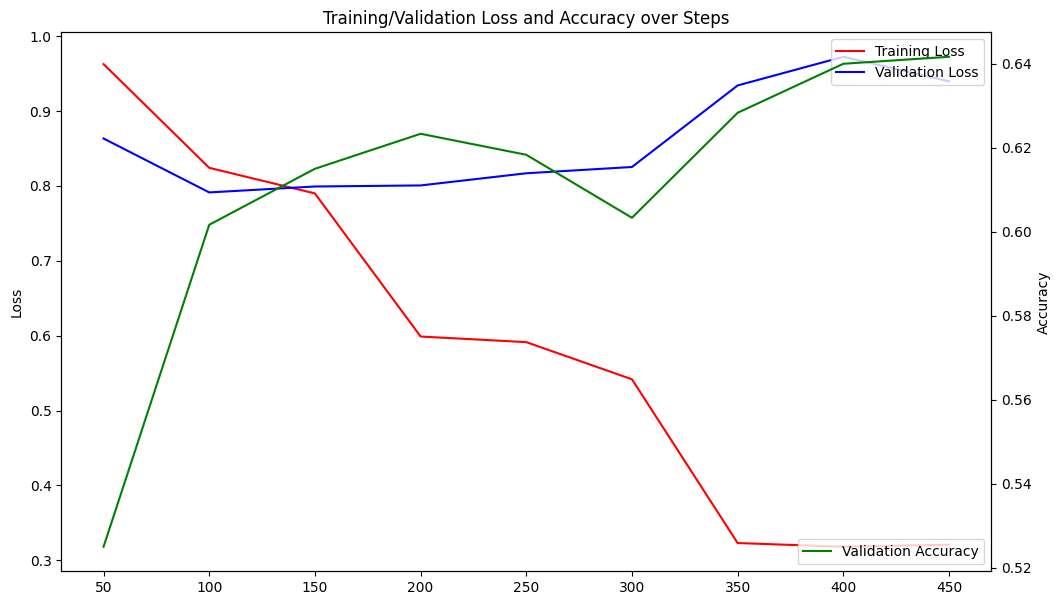

In [93]:
plot_training_history(trainer)

#### BERT Custom

##### 1

In [155]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # If encodings is a dict (tokenizer output)
        if hasattr(self.encodings, 'items'):
            item = {key: val[idx] for key, val in self.encodings.items()}
        else:
            # Assume encodings is a numpy array or list (embeddings)
            item = {'input_ids': torch.tensor(self.encodings[idx], dtype=torch.float)}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [156]:
train_dataset = CustomDataset(train_encodings, labels_train)
val_dataset = CustomDataset(val_encodings, labels_val)

In [192]:
import torch.nn as nn

class EmbeddingClassifier(nn.Module):
    def __init__(self, input_dim, num_labels):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_labels)
    def forward(self, input_ids=None, labels=None, **kwargs):
        logits = self.fc(input_ids)
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

model = EmbeddingClassifier(input_dim=768, num_labels=NUM_LABELS)
train_dataset = CustomDataset(train_x_sen_mean, labels_train)
val_dataset = CustomDataset(test_x_sen_mean, labels_val)

In [193]:
import torch
import torch.nn as nn
from transformers import BertModel


class DeepBertClassifier(nn.Module):
    def __init__(self, num_labels=3, dropout_prob=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        hidden_size = self.bert.config.hidden_size

        # Four hidden layers after BERT
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(32, num_labels)  # 3 output classes

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.pooler_output
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.dropout(torch.relu(self.fc4(x)))
        logits = self.classifier(x)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

In [194]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [195]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.052400,1.040959,0.450000,0.222113,0.415190,0.340222
100,1.034600,1.032069,0.467500,0.274361,0.369334,0.358051
150,1.031400,1.024702,0.472500,0.285979,0.349859,0.363056
200,1.020200,1.017982,0.507500,0.346025,0.363487,0.397165
250,1.005900,1.012325,0.495000,0.322525,0.367961,0.384032
300,1.018900,1.005944,0.502500,0.340414,0.357037,0.392779
350,1.013600,1.000761,0.520000,0.365386,0.363014,0.410298
400,0.986100,0.994984,0.522500,0.366102,0.366243,0.411872
450,0.972500,0.990778,0.525000,0.368768,0.369645,0.414065
500,1.006100,0.985996,0.522500,0.367452,0.362179,0.412491


TrainOutput(global_step=3000, training_loss=0.9359016621907552, metrics={'train_runtime': 18.3423, 'train_samples_per_second': 2616.895, 'train_steps_per_second': 163.556, 'total_flos': 0.0, 'train_loss': 0.9359016621907552, 'epoch': 30.0})

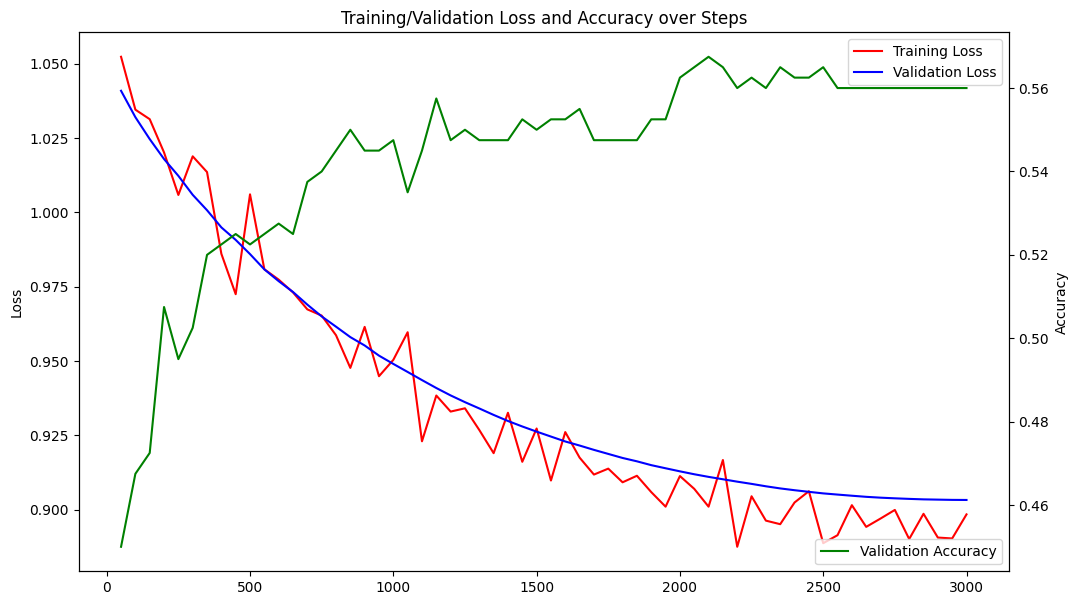

In [196]:
plot_training_history(trainer)

##### 2

In [201]:
class DeepBertClassifier(nn.Module):
    def __init__(self, num_labels=3, dropout_prob=0.4):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        hidden_size = self.bert.config.hidden_size
        self.fc1 = nn.Linear(hidden_size, 128)
        self.norm1 = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, 64)
        self.norm2 = nn.LayerNorm(64)
        self.fc3 = nn.Linear(64, 32)
        self.norm3 = nn.LayerNorm(32)
        self.fc4 = nn.Linear(32, 16)
        self.norm4 = nn.LayerNorm(16)
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(16, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = self.dropout(nn.GELU()(self.norm1(self.fc1(outputs.pooler_output))))
        x = self.dropout(nn.GELU()(self.norm2(self.fc2(x))))
        x = self.dropout(nn.GELU()(self.norm3(self.fc3(x))))
        x = self.dropout(nn.GELU()(self.norm4(self.fc4(x))))
        logits = self.classifier(x)
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

In [202]:
training_args = TrainingArguments(
    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    num_train_epochs=30,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./multi-class-logs',
    logging_steps=50,
    eval_steps=50,
    save_steps=50,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

In [203]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [204]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.826400,0.845883,0.595000,0.557598,0.566347,0.552620
100,0.837000,0.844681,0.595000,0.559930,0.567181,0.555432
150,0.830200,0.843509,0.600000,0.561498,0.573163,0.555458
200,0.827500,0.842436,0.597500,0.564559,0.571321,0.560127
250,0.825800,0.841575,0.597500,0.561097,0.571882,0.555457
300,0.827300,0.840125,0.597500,0.562987,0.569373,0.558888
350,0.843500,0.839226,0.595000,0.560812,0.567330,0.556695
400,0.804500,0.838135,0.595000,0.560812,0.567330,0.556695
450,0.809900,0.837741,0.597500,0.559389,0.571389,0.553265
500,0.834100,0.836465,0.600000,0.565475,0.573950,0.560461


TrainOutput(global_step=3000, training_loss=0.8090347290039063, metrics={'train_runtime': 18.4297, 'train_samples_per_second': 2604.485, 'train_steps_per_second': 162.78, 'total_flos': 0.0, 'train_loss': 0.8090347290039063, 'epoch': 30.0})

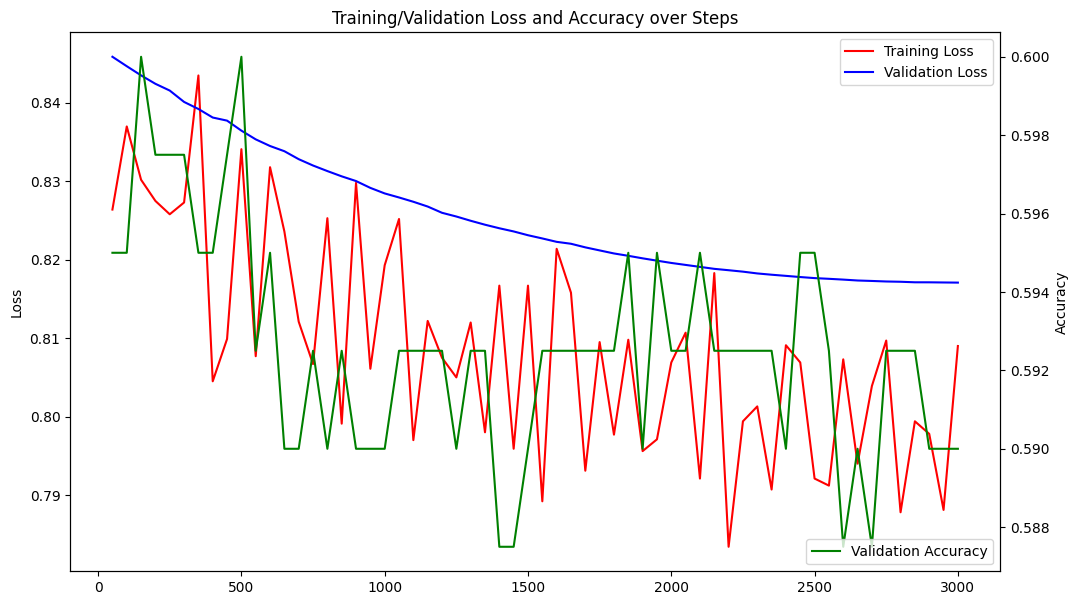

In [205]:
plot_training_history(trainer)

##### 3

In [94]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id
    )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [98]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {k: np.array(v) for k, v in encodings.items()}
        self.labels = np.array(labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [103]:
training_args = TrainingArguments(
    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./multi-class-logs',
    logging_steps=50,
    eval_steps=50,
    save_steps=50,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    remove_unused_columns=False
)

In [104]:
train_dataset = CustomDataset(train_encodings, labels_train)
val_dataset = CustomDataset(val_encodings, labels_val)

In [105]:
from transformers import EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [106]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.980600,0.923601,0.533333,0.377350,0.429122,0.437471
100,0.886600,0.895729,0.571667,0.453430,0.574443,0.553523
150,0.846600,0.845872,0.588333,0.511427,0.565071,0.541771
200,0.765900,0.811731,0.591667,0.548393,0.552252,0.588580
250,0.740600,0.804362,0.603333,0.579118,0.577084,0.591417
300,0.704500,0.803055,0.603333,0.567418,0.565420,0.605548
350,0.612500,0.805792,0.616667,0.587982,0.598170,0.588443
400,0.579400,0.830504,0.611667,0.567766,0.572707,0.600017
450,0.626700,0.838583,0.616667,0.564883,0.585814,0.596236


TrainOutput(global_step=450, training_loss=0.7492552524142795, metrics={'train_runtime': 103.1553, 'train_samples_per_second': 232.659, 'train_steps_per_second': 14.541, 'total_flos': 680805968371200.0, 'train_loss': 0.7492552524142795, 'epoch': 3.0})

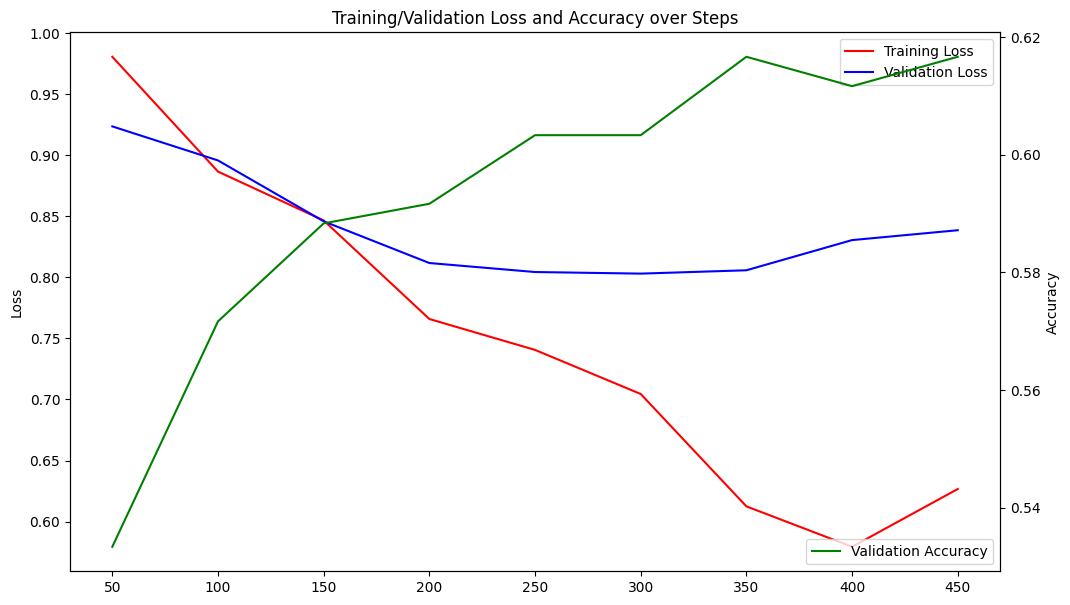

In [107]:
plot_training_history(trainer)

##### 4

In [ ]:
from transformers import TrainingArguments, EarlyStoppingCallback

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id
)

model.to(device)

training_args = TrainingArguments(
    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./multi-class-logs',
    logging_steps=50,
    eval_steps=50,
    save_steps=50,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.090700,0.968821,0.525000,0.379451,0.346440,0.420879
100,0.914500,0.855594,0.582500,0.526588,0.610745,0.517566
150,0.775200,0.797665,0.620000,0.609536,0.613968,0.614222
200,0.730200,0.778112,0.642500,0.636962,0.637469,0.643657
250,0.623800,0.795695,0.635000,0.627704,0.651206,0.639222
300,0.614600,0.768425,0.660000,0.661078,0.654577,0.684336
350,0.567600,0.796329,0.640000,0.635483,0.648944,0.641750
400,0.466200,0.772328,0.655000,0.650789,0.658270,0.655241


TrainOutput(global_step=400, training_loss=0.722853422164917, metrics={'train_runtime': 94.0329, 'train_samples_per_second': 85.077, 'train_steps_per_second': 5.317, 'total_flos': 605160860774400.0, 'train_loss': 0.722853422164917, 'epoch': 4.0})

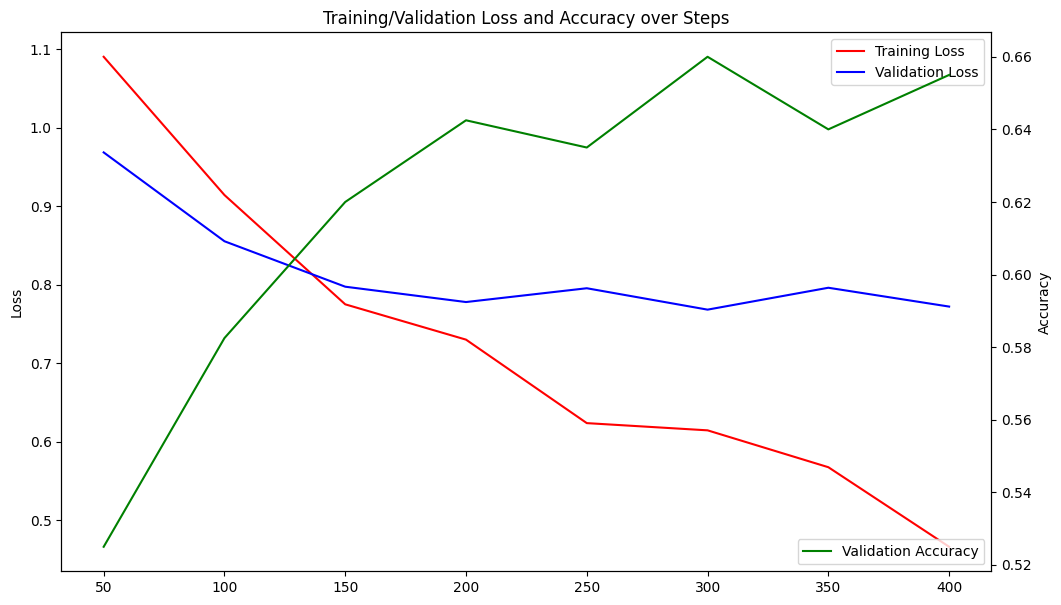

In [ ]:
plot_training_history(trainer)

##### 5

In [ ]:
from transformers import TrainingArguments, EarlyStoppingCallback

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id
)

model.to(device)

training_args = TrainingArguments(
    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    num_train_epochs=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-5,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./multi-class-logs',
    logging_steps=50,
    eval_steps=50,
    save_steps=50,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.011000,0.992939,0.472500,0.345742,0.325714,0.387836
100,0.957100,0.878148,0.557500,0.519522,0.538510,0.512506
150,0.894200,0.821875,0.582500,0.545091,0.625822,0.570225
200,0.824200,0.778961,0.672500,0.671441,0.683983,0.674976
250,0.713000,0.811719,0.617500,0.604718,0.709164,0.612553
300,0.642100,0.752252,0.612500,0.600047,0.628494,0.650890
350,0.660000,0.671717,0.692500,0.693977,0.687766,0.707245
400,0.662700,0.688590,0.692500,0.696093,0.703928,0.720017
450,0.488600,0.706215,0.685000,0.677792,0.703241,0.679055
500,0.479000,0.668806,0.692500,0.694320,0.690029,0.699454


TrainOutput(global_step=750, training_loss=0.6112062174479167, metrics={'train_runtime': 152.5277, 'train_samples_per_second': 209.798, 'train_steps_per_second': 26.225, 'total_flos': 567338306976000.0, 'train_loss': 0.6112062174479167, 'epoch': 3.75})

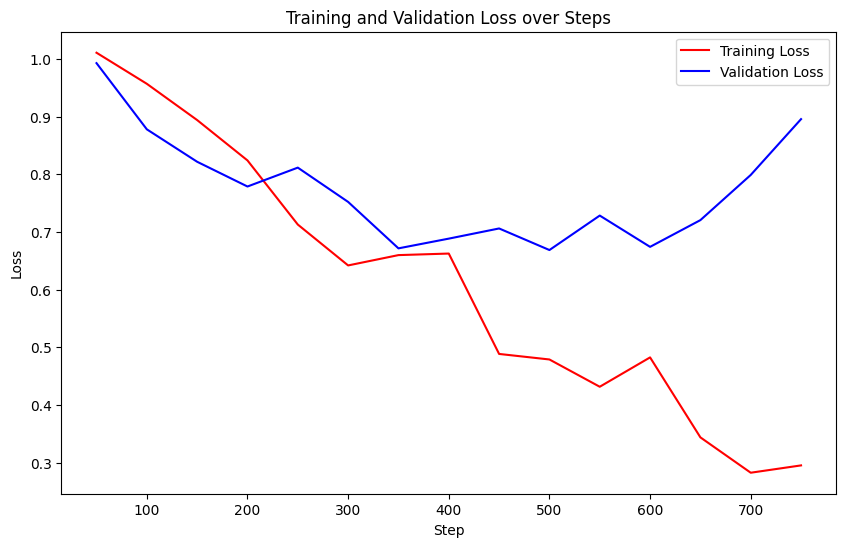

In [ ]:
plot_training_history(trainer)

In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Custon DNN

#### 1. Mix 2

Epoch 1/25: 100%|██████████| 100/100 [00:00<00:00, 176.54it/s]


Validation Loss: 0.7449, Accuracy: 0.6325


Epoch 2/25: 100%|██████████| 100/100 [00:00<00:00, 268.16it/s]


Validation Loss: 0.7280, Accuracy: 0.6650


Epoch 3/25: 100%|██████████| 100/100 [00:00<00:00, 273.40it/s]


Validation Loss: 0.7170, Accuracy: 0.6450


Epoch 4/25: 100%|██████████| 100/100 [00:00<00:00, 273.22it/s]


Validation Loss: 0.7162, Accuracy: 0.6650


Epoch 5/25: 100%|██████████| 100/100 [00:00<00:00, 265.79it/s]


Validation Loss: 0.7200, Accuracy: 0.6725


Epoch 6/25: 100%|██████████| 100/100 [00:00<00:00, 274.62it/s]


Validation Loss: 0.7233, Accuracy: 0.6900


Epoch 7/25: 100%|██████████| 100/100 [00:00<00:00, 280.19it/s]


Validation Loss: 0.7836, Accuracy: 0.6925


Epoch 8/25: 100%|██████████| 100/100 [00:00<00:00, 269.95it/s]


Validation Loss: 0.7983, Accuracy: 0.6575


Epoch 9/25: 100%|██████████| 100/100 [00:00<00:00, 284.55it/s]


Validation Loss: 0.7987, Accuracy: 0.6725


Epoch 10/25: 100%|██████████| 100/100 [00:00<00:00, 267.44it/s]


Validation Loss: 0.8013, Accuracy: 0.6775


Epoch 11/25: 100%|██████████| 100/100 [00:00<00:00, 279.29it/s]


Validation Loss: 0.8113, Accuracy: 0.6625


Epoch 12/25: 100%|██████████| 100/100 [00:00<00:00, 273.73it/s]


Validation Loss: 0.8073, Accuracy: 0.6700


Epoch 13/25: 100%|██████████| 100/100 [00:00<00:00, 278.08it/s]


Validation Loss: 0.8062, Accuracy: 0.6625


Epoch 14/25: 100%|██████████| 100/100 [00:00<00:00, 272.97it/s]


Validation Loss: 0.8063, Accuracy: 0.6750


Epoch 15/25: 100%|██████████| 100/100 [00:00<00:00, 269.64it/s]


Validation Loss: 0.8029, Accuracy: 0.6700


Epoch 16/25: 100%|██████████| 100/100 [00:00<00:00, 284.73it/s]


Validation Loss: 0.8065, Accuracy: 0.6650


Epoch 17/25: 100%|██████████| 100/100 [00:00<00:00, 240.32it/s]


Validation Loss: 0.8008, Accuracy: 0.6725


Epoch 18/25: 100%|██████████| 100/100 [00:00<00:00, 270.23it/s]


Validation Loss: 0.8175, Accuracy: 0.6700


Epoch 19/25: 100%|██████████| 100/100 [00:00<00:00, 280.86it/s]


Validation Loss: 0.8090, Accuracy: 0.6700


Epoch 20/25: 100%|██████████| 100/100 [00:00<00:00, 283.27it/s]


Validation Loss: 0.8041, Accuracy: 0.6750


Epoch 21/25: 100%|██████████| 100/100 [00:00<00:00, 280.16it/s]


Validation Loss: 0.8060, Accuracy: 0.6750


Epoch 22/25: 100%|██████████| 100/100 [00:00<00:00, 282.68it/s]


Validation Loss: 0.8084, Accuracy: 0.6800


Epoch 23/25: 100%|██████████| 100/100 [00:00<00:00, 288.57it/s]


Validation Loss: 0.8022, Accuracy: 0.6675


Epoch 24/25: 100%|██████████| 100/100 [00:00<00:00, 283.58it/s]


Validation Loss: 0.8082, Accuracy: 0.6700


Epoch 25/25: 100%|██████████| 100/100 [00:00<00:00, 282.52it/s]


Validation Loss: 0.8086, Accuracy: 0.6675


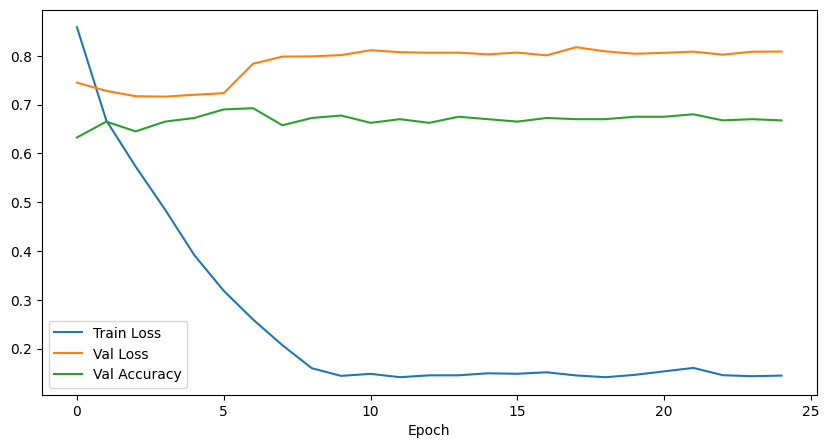

In [275]:
from torch import nn

model = nn.Sequential(
    nn.Linear(3072, 1512),
    nn.BatchNorm1d(1512),
    nn.GELU(),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(1512, 256),
    nn.GELU(),
    nn.Dropout(0.2),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, NUM_LABELS)
)

model = model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

num_epochs = 10
num_warmup_steps = 10
num_training_steps = len(train_dataloader) * num_epochs
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

from torch.utils.data import Dataset, DataLoader

# 1. Create a Dataset for embeddings
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return {'input_ids': self.X[idx], 'labels': self.y[idx]}


batch_size = 16
train_dataset = EmbeddingDataset(train_x_sen_mix2, train_y_mapped)
val_dataset = EmbeddingDataset(test_x_sen_mix2, test_y_mapped)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


def train(model, train_loader, val_loader, optimizer, scheduler, num_epochs=10):
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
        # Validation
        model.eval()
        eval_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                logits = model(input_ids)
                loss = loss_fn(logits, labels)
                eval_loss += loss.item()
                preds = torch.argmax(logits, dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_losses.append(eval_loss / len(val_loader))
        val_accuracies.append(correct / total)
        print(f"Validation Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracies[-1]:.4f}")
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


train(model, train_loader, val_loader, optimizer, scheduler, num_epochs=25)

#### 2. Mean

Epoch 1/25: 100%|██████████| 100/100 [00:00<00:00, 214.84it/s]


Validation Loss: 0.7927, Accuracy: 0.6300


Epoch 2/25: 100%|██████████| 100/100 [00:00<00:00, 458.19it/s]


Validation Loss: 0.7757, Accuracy: 0.6550


Epoch 3/25: 100%|██████████| 100/100 [00:00<00:00, 507.89it/s]


Validation Loss: 0.7429, Accuracy: 0.6175


Epoch 4/25: 100%|██████████| 100/100 [00:00<00:00, 520.67it/s]


Validation Loss: 0.7026, Accuracy: 0.6750


Epoch 5/25: 100%|██████████| 100/100 [00:00<00:00, 522.94it/s]


Validation Loss: 0.7108, Accuracy: 0.6375


Epoch 6/25: 100%|██████████| 100/100 [00:00<00:00, 516.22it/s]


Validation Loss: 0.6908, Accuracy: 0.6475


Epoch 7/25: 100%|██████████| 100/100 [00:00<00:00, 513.72it/s]


Validation Loss: 0.7069, Accuracy: 0.6400


Epoch 8/25: 100%|██████████| 100/100 [00:00<00:00, 518.07it/s]


Validation Loss: 0.6700, Accuracy: 0.6725


Epoch 9/25: 100%|██████████| 100/100 [00:00<00:00, 508.74it/s]


Validation Loss: 0.6605, Accuracy: 0.6725


Epoch 10/25: 100%|██████████| 100/100 [00:00<00:00, 495.46it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 11/25: 100%|██████████| 100/100 [00:00<00:00, 499.87it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 12/25: 100%|██████████| 100/100 [00:00<00:00, 509.54it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 13/25: 100%|██████████| 100/100 [00:00<00:00, 508.51it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 14/25: 100%|██████████| 100/100 [00:00<00:00, 479.20it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 15/25: 100%|██████████| 100/100 [00:00<00:00, 490.68it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 16/25: 100%|██████████| 100/100 [00:00<00:00, 502.43it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 17/25: 100%|██████████| 100/100 [00:00<00:00, 488.65it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 18/25: 100%|██████████| 100/100 [00:00<00:00, 494.04it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 19/25: 100%|██████████| 100/100 [00:00<00:00, 485.20it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 20/25: 100%|██████████| 100/100 [00:00<00:00, 500.74it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 21/25: 100%|██████████| 100/100 [00:00<00:00, 494.43it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 22/25: 100%|██████████| 100/100 [00:00<00:00, 487.67it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 23/25: 100%|██████████| 100/100 [00:00<00:00, 507.09it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 24/25: 100%|██████████| 100/100 [00:00<00:00, 490.38it/s]


Validation Loss: 0.6633, Accuracy: 0.6700


Epoch 25/25: 100%|██████████| 100/100 [00:00<00:00, 472.89it/s]

Validation Loss: 0.6633, Accuracy: 0.6700


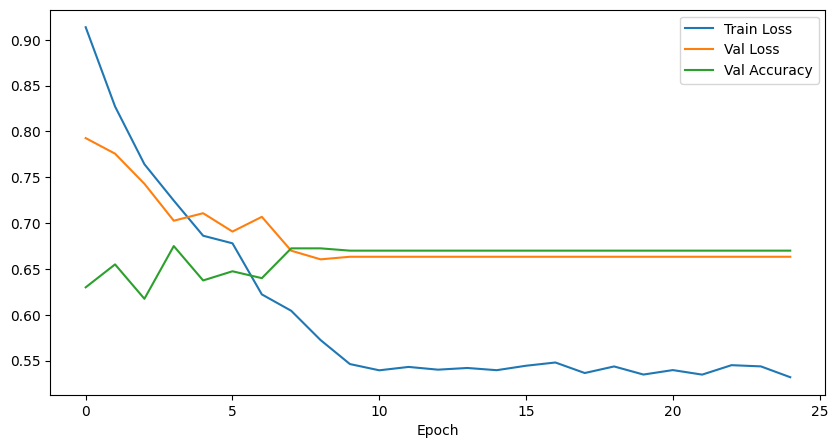

In [271]:
model = nn.Sequential(
    nn.Linear(768, 1512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1512, 256),
    nn.GELU(),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, NUM_LABELS)
)

model = model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.02)

num_epochs = 10
num_warmup_steps = 10
num_training_steps = len(train_dataloader) * num_epochs
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

from torch.utils.data import Dataset, DataLoader

# 1. Create a Dataset for embeddings
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return {'input_ids': self.X[idx], 'labels': self.y[idx]}


batch_size = 16
train_dataset = EmbeddingDataset(train_x_sen_mean, train_y_mapped)
val_dataset = EmbeddingDataset(test_x_sen_mean, test_y_mapped)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

train(model, train_loader, val_loader, optimizer, scheduler, num_epochs=25)

#### 3. Max

In [273]:
len(train_x_sen_max[0])

768

Epoch 1/25: 100%|██████████| 100/100 [00:00<00:00, 254.80it/s]


Validation Loss: 0.8340, Accuracy: 0.5850


Epoch 2/25: 100%|██████████| 100/100 [00:00<00:00, 519.42it/s]


Validation Loss: 0.8420, Accuracy: 0.5700


Epoch 3/25: 100%|██████████| 100/100 [00:00<00:00, 501.68it/s]


Validation Loss: 0.7507, Accuracy: 0.6400


Epoch 4/25: 100%|██████████| 100/100 [00:00<00:00, 500.16it/s]


Validation Loss: 0.7311, Accuracy: 0.6650


Epoch 5/25: 100%|██████████| 100/100 [00:00<00:00, 515.69it/s]


Validation Loss: 0.7536, Accuracy: 0.6100


Epoch 6/25: 100%|██████████| 100/100 [00:00<00:00, 492.14it/s]


Validation Loss: 0.7391, Accuracy: 0.6375


Epoch 7/25: 100%|██████████| 100/100 [00:00<00:00, 517.12it/s]


Validation Loss: 0.7194, Accuracy: 0.6500


Epoch 8/25: 100%|██████████| 100/100 [00:00<00:00, 482.59it/s]


Validation Loss: 0.7481, Accuracy: 0.6525


Epoch 9/25: 100%|██████████| 100/100 [00:00<00:00, 492.82it/s]


Validation Loss: 0.7479, Accuracy: 0.6375


Epoch 10/25: 100%|██████████| 100/100 [00:00<00:00, 482.66it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 11/25: 100%|██████████| 100/100 [00:00<00:00, 500.14it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 12/25: 100%|██████████| 100/100 [00:00<00:00, 468.51it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 13/25: 100%|██████████| 100/100 [00:00<00:00, 491.02it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 14/25: 100%|██████████| 100/100 [00:00<00:00, 479.67it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 15/25: 100%|██████████| 100/100 [00:00<00:00, 487.45it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 16/25: 100%|██████████| 100/100 [00:00<00:00, 446.43it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 17/25: 100%|██████████| 100/100 [00:00<00:00, 476.47it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 18/25: 100%|██████████| 100/100 [00:00<00:00, 487.86it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 19/25: 100%|██████████| 100/100 [00:00<00:00, 483.96it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 20/25: 100%|██████████| 100/100 [00:00<00:00, 470.21it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 21/25: 100%|██████████| 100/100 [00:00<00:00, 480.39it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 22/25: 100%|██████████| 100/100 [00:00<00:00, 475.03it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 23/25: 100%|██████████| 100/100 [00:00<00:00, 489.92it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 24/25: 100%|██████████| 100/100 [00:00<00:00, 480.40it/s]


Validation Loss: 0.7500, Accuracy: 0.6475


Epoch 25/25: 100%|██████████| 100/100 [00:00<00:00, 474.15it/s]

Validation Loss: 0.7500, Accuracy: 0.6475


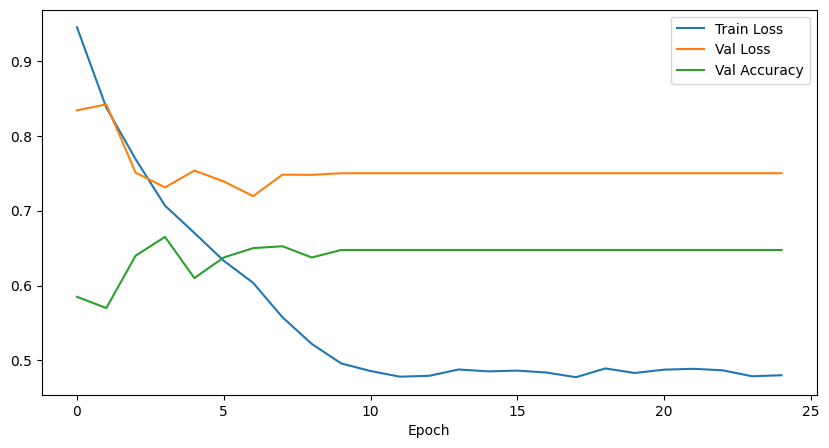

In [274]:
model = nn.Sequential(
    nn.Linear(768, 1512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1512, 256),
    nn.GELU(),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, NUM_LABELS)
)

model = model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.02)

num_epochs = 10
num_warmup_steps = 10
num_training_steps = len(train_dataloader) * num_epochs
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

from torch.utils.data import Dataset, DataLoader

# 1. Create a Dataset for embeddings
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return {'input_ids': self.X[idx], 'labels': self.y[idx]}


batch_size = 16
train_dataset = EmbeddingDataset(train_x_sen_max, train_y_mapped)
val_dataset = EmbeddingDataset(test_x_sen_max, test_y_mapped)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

train(model, train_loader, val_loader, optimizer, scheduler, num_epochs=25)

#### 4. Mix

Epoch 1/25: 100%|██████████| 100/100 [00:00<00:00, 259.96it/s]


Validation Loss: 0.7395, Accuracy: 0.6325


Epoch 2/25: 100%|██████████| 100/100 [00:00<00:00, 449.21it/s]


Validation Loss: 0.7217, Accuracy: 0.6775


Epoch 3/25: 100%|██████████| 100/100 [00:00<00:00, 361.36it/s]


Validation Loss: 0.7421, Accuracy: 0.6675


Epoch 4/25: 100%|██████████| 100/100 [00:00<00:00, 416.55it/s]


Validation Loss: 0.8687, Accuracy: 0.6725


Epoch 5/25: 100%|██████████| 100/100 [00:00<00:00, 442.48it/s]


Validation Loss: 0.9868, Accuracy: 0.6350


Epoch 6/25: 100%|██████████| 100/100 [00:00<00:00, 437.83it/s]


Validation Loss: 0.9837, Accuracy: 0.6500


Epoch 7/25: 100%|██████████| 100/100 [00:00<00:00, 463.20it/s]


Validation Loss: 1.1065, Accuracy: 0.6400


Epoch 8/25: 100%|██████████| 100/100 [00:00<00:00, 449.59it/s]


Validation Loss: 1.0521, Accuracy: 0.6525


Epoch 9/25: 100%|██████████| 100/100 [00:00<00:00, 366.99it/s]


Validation Loss: 1.0834, Accuracy: 0.6550


Epoch 10/25: 100%|██████████| 100/100 [00:00<00:00, 468.57it/s]


Validation Loss: 1.1038, Accuracy: 0.6600


Epoch 11/25: 100%|██████████| 100/100 [00:00<00:00, 479.72it/s]


Validation Loss: 1.0815, Accuracy: 0.6650


Epoch 12/25: 100%|██████████| 100/100 [00:00<00:00, 455.64it/s]


Validation Loss: 1.0693, Accuracy: 0.6600


Epoch 13/25: 100%|██████████| 100/100 [00:00<00:00, 444.14it/s]


Validation Loss: 1.0632, Accuracy: 0.6600


Epoch 14/25: 100%|██████████| 100/100 [00:00<00:00, 452.32it/s]


Validation Loss: 1.1060, Accuracy: 0.6500


Epoch 15/25: 100%|██████████| 100/100 [00:00<00:00, 439.54it/s]


Validation Loss: 1.0669, Accuracy: 0.6650


Epoch 16/25: 100%|██████████| 100/100 [00:00<00:00, 482.15it/s]


Validation Loss: 1.0533, Accuracy: 0.6700


Epoch 17/25: 100%|██████████| 100/100 [00:00<00:00, 455.44it/s]


Validation Loss: 1.0636, Accuracy: 0.6650


Epoch 18/25: 100%|██████████| 100/100 [00:00<00:00, 457.70it/s]


Validation Loss: 1.0587, Accuracy: 0.6625


Epoch 19/25: 100%|██████████| 100/100 [00:00<00:00, 461.01it/s]


Validation Loss: 1.0865, Accuracy: 0.6550


Epoch 20/25: 100%|██████████| 100/100 [00:00<00:00, 458.29it/s]


Validation Loss: 1.0957, Accuracy: 0.6600


Epoch 21/25: 100%|██████████| 100/100 [00:00<00:00, 448.19it/s]


Validation Loss: 1.0851, Accuracy: 0.6625


Epoch 22/25: 100%|██████████| 100/100 [00:00<00:00, 451.66it/s]


Validation Loss: 1.0633, Accuracy: 0.6600


Epoch 23/25: 100%|██████████| 100/100 [00:00<00:00, 456.41it/s]


Validation Loss: 1.0630, Accuracy: 0.6675


Epoch 24/25: 100%|██████████| 100/100 [00:00<00:00, 449.88it/s]


Validation Loss: 1.0743, Accuracy: 0.6550


Epoch 25/25: 100%|██████████| 100/100 [00:00<00:00, 459.83it/s]


Validation Loss: 1.0945, Accuracy: 0.6600


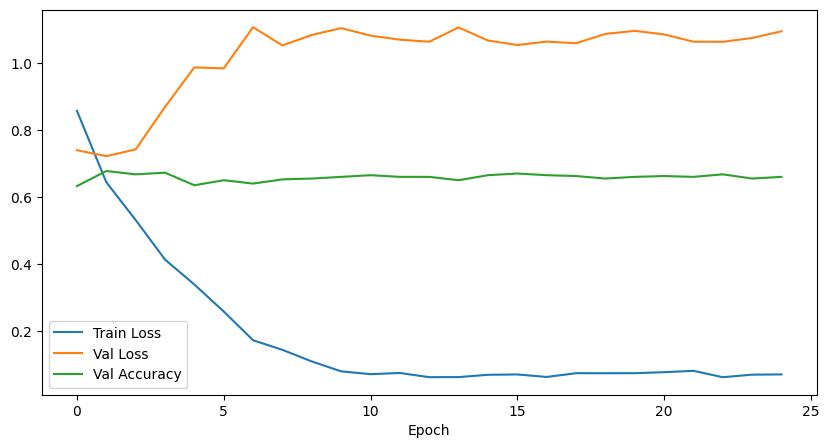

In [279]:
model = nn.Sequential(
    nn.Linear(768, 1024),
    nn.BatchNorm1d(1024),
    nn.GELU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 256),
    nn.BatchNorm1d(256),
    nn.GELU(),
    nn.Dropout(0.2),
    nn.Linear(256, NUM_LABELS)
)

model = model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

num_epochs = 10
num_warmup_steps = 10
num_training_steps = len(train_dataloader) * num_epochs
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

from torch.utils.data import Dataset, DataLoader

# 1. Create a Dataset for embeddings
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return {'input_ids': self.X[idx], 'labels': self.y[idx]}


batch_size = 16
train_dataset = EmbeddingDataset(train_x_sen_mix, train_y_mapped)
val_dataset = EmbeddingDataset(test_x_sen_mix, test_y_mapped)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

train(model, train_loader, val_loader, optimizer, scheduler, num_epochs=25)

#### 5. All

In [280]:
# Concatenate all embeddings for each sample
train_x_all = np.concatenate([
    np.array(train_x_sen_mean),
    np.array(train_x_sen_max),
    np.array(train_x_sen_mix),
    np.array(train_x_sen_sum),
    np.array(train_x_sen_concat),
    np.array(train_x_sen_mix2)
], axis=1)

test_x_all = np.concatenate([
    np.array(test_x_sen_mean),
    np.array(test_x_sen_max),
    np.array(test_x_sen_mix),
    np.array(test_x_sen_sum),
    np.array(test_x_sen_concat),
    np.array(test_x_sen_mix2)
], axis=1)

print(train_x_all.shape)  # (num_samples, total_features)

(1600, 13824)


Epoch 1/25: 100%|██████████| 100/100 [00:01<00:00, 92.18it/s]


Validation Loss: 0.7663, Accuracy: 0.6175


Epoch 2/25: 100%|██████████| 100/100 [00:00<00:00, 113.16it/s]


Validation Loss: 0.8014, Accuracy: 0.6525


Epoch 3/25: 100%|██████████| 100/100 [00:00<00:00, 111.93it/s]


Validation Loss: 0.7630, Accuracy: 0.6675


Epoch 4/25: 100%|██████████| 100/100 [00:00<00:00, 113.85it/s]


Validation Loss: 0.8163, Accuracy: 0.6625


Epoch 5/25: 100%|██████████| 100/100 [00:00<00:00, 109.82it/s]


Validation Loss: 0.8978, Accuracy: 0.6625


Epoch 6/25: 100%|██████████| 100/100 [00:00<00:00, 111.00it/s]


Validation Loss: 0.9251, Accuracy: 0.6725


Epoch 7/25: 100%|██████████| 100/100 [00:00<00:00, 113.48it/s]


Validation Loss: 0.9585, Accuracy: 0.6750


Epoch 8/25: 100%|██████████| 100/100 [00:00<00:00, 111.60it/s]


Validation Loss: 1.1304, Accuracy: 0.6525


Epoch 9/25: 100%|██████████| 100/100 [00:00<00:00, 113.11it/s]


Validation Loss: 1.0618, Accuracy: 0.6750


Epoch 10/25: 100%|██████████| 100/100 [00:00<00:00, 113.19it/s]


Validation Loss: 1.0758, Accuracy: 0.6600


Epoch 11/25: 100%|██████████| 100/100 [00:00<00:00, 113.25it/s]


Validation Loss: 1.0703, Accuracy: 0.6550


Epoch 12/25: 100%|██████████| 100/100 [00:00<00:00, 114.50it/s]


Validation Loss: 1.0521, Accuracy: 0.6675


Epoch 13/25: 100%|██████████| 100/100 [00:00<00:00, 112.86it/s]


Validation Loss: 1.0774, Accuracy: 0.6550


Epoch 14/25: 100%|██████████| 100/100 [00:00<00:00, 113.77it/s]


Validation Loss: 1.0609, Accuracy: 0.6675


Epoch 15/25: 100%|██████████| 100/100 [00:00<00:00, 112.25it/s]


Validation Loss: 1.0714, Accuracy: 0.6675


Epoch 16/25: 100%|██████████| 100/100 [00:00<00:00, 112.09it/s]


Validation Loss: 1.0447, Accuracy: 0.6700


Epoch 17/25: 100%|██████████| 100/100 [00:00<00:00, 112.39it/s]


Validation Loss: 1.0803, Accuracy: 0.6650


Epoch 18/25: 100%|██████████| 100/100 [00:00<00:00, 111.31it/s]


Validation Loss: 1.0819, Accuracy: 0.6650


Epoch 19/25: 100%|██████████| 100/100 [00:00<00:00, 112.11it/s]


Validation Loss: 1.1088, Accuracy: 0.6625


Epoch 20/25: 100%|██████████| 100/100 [00:00<00:00, 112.50it/s]


Validation Loss: 1.0714, Accuracy: 0.6575


Epoch 21/25: 100%|██████████| 100/100 [00:00<00:00, 112.27it/s]


Validation Loss: 1.0788, Accuracy: 0.6650


Epoch 22/25: 100%|██████████| 100/100 [00:00<00:00, 114.86it/s]


Validation Loss: 1.0528, Accuracy: 0.6575


Epoch 23/25: 100%|██████████| 100/100 [00:00<00:00, 114.46it/s]


Validation Loss: 1.0746, Accuracy: 0.6625


Epoch 24/25: 100%|██████████| 100/100 [00:00<00:00, 113.50it/s]


Validation Loss: 1.0597, Accuracy: 0.6675


Epoch 25/25: 100%|██████████| 100/100 [00:00<00:00, 109.69it/s]


Validation Loss: 1.0624, Accuracy: 0.6625


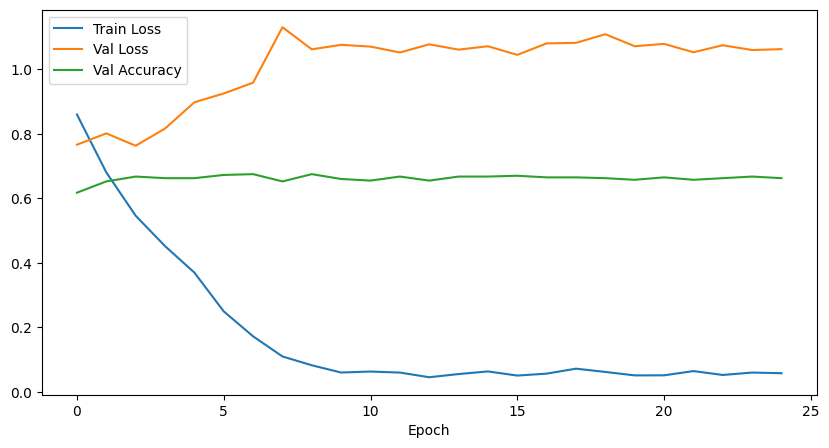

In [282]:
# Example: if each embedding is 768-dim, and you have 6 types, input_dim = 768*6 = 4608
input_dim = train_x_all.shape[1]

model = nn.Sequential(
    nn.Linear(input_dim, 1024),
    nn.BatchNorm1d(1024),
    nn.GELU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 256),
    nn.BatchNorm1d(256),
    nn.GELU(),
    nn.Dropout(0.2),
    nn.Linear(256, NUM_LABELS)
)

model = model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

num_epochs = 10
num_warmup_steps = 10
num_training_steps = len(train_dataloader) * num_epochs
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

from torch.utils.data import Dataset, DataLoader

# 1. Create a Dataset for embeddings
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return {'input_ids': self.X[idx], 'labels': self.y[idx]}


batch_size = 16
train_dataset = EmbeddingDataset(train_x_all, train_y_mapped)
val_dataset = EmbeddingDataset(test_x_all, test_y_mapped)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

train(model, train_loader, val_loader, optimizer, scheduler, num_epochs=25)

## Results

## Simple ML

In [89]:
results = pd.DataFrame(results, columns=['Embedding', 'Model', 'Optimized', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results = results.sort_values(by='F1 Score', ascending=False)

In [90]:
results.head(10)

,Embedding,Model,Optimized,Accuracy,F1 Score,Precision,Recall
36,mean,SVC,True,0.7025,0.702219,0.702557,0.7025
56,sum,SVC,True,0.6900,0.689806,0.689956,0.6900
0,mean,LogisticRegression,False,0.6850,0.685167,0.686242,0.6850
51,mix,SVC,True,0.6825,0.682718,0.683091,0.6825
46,full,SVC,True,0.6750,0.675117,0.675671,0.6750
66,mix2,SVC,True,0.6750,0.674006,0.674376,0.6750
41,max,SVC,True,0.6725,0.672599,0.672739,0.6725
20,sum,LogisticRegression,False,0.6675,0.667645,0.668123,0.6675
25,concat,LogisticRegression,False,0.6650,0.664696,0.664754,0.6650
69,mix2,KNeighborsClassifier,True,0.6625,0.664078,0.668838,0.6625


# Classsification - Other Features

## Scale

In [342]:
training.columns

Index(['link', 'date', 'title', 'content', 'vectors_L6_v2', 'vectors_distil',
       'classes_distil', 'Scale_fe', 'Type of Vessel_fe', 'Vessel Size_fe',
       'Sea Route_fe', 'Duration of Positive Impact_fe', 'Impact_fe',
       'Hire Rate Impact_fe', 'Scale_rag', 'Type of Vessel_rag',
       'Vessel Size_rag', 'Sea Route_rag', 'Duration of Positive Impact_rag',
       'Impact_rag', 'Hire Rate Impact_rag', 'Scale_idfe',
       'Type of Vessel_idfe', 'Vessel Size_idfe', 'Sea Route_idfe',
       'Duration of Positive Impact_idfe', 'Impact_idfe',
       'Hire Rate Impact_idfe', 'Scale_idrbfe', 'Type of Vessel_idrbfe',
       'Vessel Size_idrbfe', 'Sea Route_idrbfe',
       'Duration of Positive Impact_idrbfe', 'Impact_idrbfe',
       'Hire Rate Impact_idrbfe', 'Hire rate impact_rag'],
      dtype='object')

In [369]:
training['Scale_idrbfe'].value_counts()

Scale_idrbfe
Global      1144
None         607
Regional     170
National      79
Name: count, dtype: int64

In [534]:
def proc_scale(scale):
    if scale == 'Global':
        return 3
    if scale == 'Regional':
        return 2
    if scale == 'National':
        return 1
    if scale == 'None':
        return 0

In [535]:
training['Scale_idrbfe'] = training['Scale_idrbfe'].apply(proc_scale)

In [373]:
__, _, train_y, test_y = train_test_split(df['bart_summ'][:2000], training['Scale_idrbfe'], test_size=0.2, random_state=42, stratify = training['Scale_idrbfe'])
# train_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0).value_counts()
# train_y = train_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0)
# test_y = test_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0)

In [374]:
train_and_evaluate_model(models, train_x_sen_mean, train_y, test_x_sen_mean, test_y, results, 'mean')
train_and_evaluate_model(models, train_x_sen_max, train_y, test_x_sen_max, test_y, results, 'max')
train_and_evaluate_model(models, train_x_full, train_y, test_x_full, test_y, results, 'full')
train_and_evaluate_model(models, train_x_sen_mix, train_y, test_x_sen_mix, test_y, results, 'mix')
train_and_evaluate_model(models, train_x_sen_sum, train_y, test_x_sen_sum, test_y, results, 'sum')
train_and_evaluate_model(models, train_x_sen_concat, train_y, test_x_sen_concat, test_y, results, 'concat')
train_and_evaluate_model(models, train_x_sen_mix2, train_y, test_x_sen_mix2, test_y, results, 'mix2')

Model: LogisticRegression
Data type: mean
Accuracy: 0.4650
F1 Score: 0.4238
Precision: 0.3978
Recall: 0.4650


Model: SVC
Data type: mean
Accuracy: 0.4550
F1 Score: 0.4292
Precision: 0.4119
Recall: 0.4550


Model: RandomForestClassifier
Data type: mean
Accuracy: 0.5575
F1 Score: 0.4257
Precision: 0.4112
Recall: 0.5575


Model: DecisionTreeClassifier
Data type: mean
Accuracy: 0.3950
F1 Score: 0.4012
Precision: 0.4084
Recall: 0.3950


Model: KNeighborsClassifier
Data type: mean
Accuracy: 0.4725
F1 Score: 0.4479
Precision: 0.4257
Recall: 0.4725


Model: LogisticRegression
Data type: max
Accuracy: 0.4825
F1 Score: 0.4529
Precision: 0.4311
Recall: 0.4825


Model: SVC
Data type: max
Accuracy: 0.4300
F1 Score: 0.4300
Precision: 0.4301
Recall: 0.4300


Model: RandomForestClassifier
Data type: max
Accuracy: 0.5650
F1 Score: 0.4275
Precision: 0.4047
Recall: 0.5650


Model: DecisionTreeClassifier
Data type: max
Accuracy: 0.4175
F1 Score: 0.4125
Precision: 0.4078
Recall: 0.4175


Model: KNeighbors

## Route

In [536]:
def proc_route(route):
    if route in ['All', 'C5', 'C3']:
        return 1
    else:
        return 0

In [537]:
training['Sea Route_idrbfe'].value_counts()

Sea Route_idrbfe
None     900
Other    565
All      517
C5        13
C3         5
Name: count, dtype: int64

In [538]:
training['Sea Route_idrbfe'] = training['Sea Route_idrbfe'].apply(proc_route)
# training['Sea Route_idrbfe'] = training['Sea Route_idrbfe'].fillna(0) 

In [647]:
all_indices = np.arange(len(df['bart_summ'][:2000]))
train_idx, test_idx, train_y, test_y = train_test_split(
    all_indices, training['Sea Route_idrbfe'], test_size=0.2, random_state=42, stratify=training['Sea Route_idrbfe']
)

# Now you can get the embeddings for train/test:
train_x_sen_mean = [all_embeddings[i] for i in train_idx]
test_x_sen_mean = [all_embeddings[i] for i in test_idx]

train_and_evaluate_model(models, train_x_sen_mean, train_y, test_x_sen_mean, test_y, results, 'mean')
train_and_evaluate_model(models, train_x_sen_max, train_y, test_x_sen_max, test_y, results, 'max')
train_and_evaluate_model(models, train_x_full, train_y, test_x_full, test_y, results, 'full')
train_and_evaluate_model(models, train_x_sen_mix, train_y, test_x_sen_mix, test_y, results, 'mix')
train_and_evaluate_model(models, train_x_sen_sum, train_y, test_x_sen_sum, test_y, results, 'sum')
train_and_evaluate_model(models, train_x_sen_concat, train_y, test_x_sen_concat, test_y, results, 'concat')
train_and_evaluate_model(models, train_x_sen_mix2, train_y, test_x_sen_mix2, test_y, results, 'mix2')

Model: LogisticRegression
Data type: mean
Accuracy: 0.7925
F1 Score: 0.7865
Precision: 0.7838
Recall: 0.7925


Model: SVC
Data type: mean
Accuracy: 0.7900
F1 Score: 0.7843
Precision: 0.7815
Recall: 0.7900


Model: RandomForestClassifier
Data type: mean
Accuracy: 0.7975
F1 Score: 0.7651
Precision: 0.7971
Recall: 0.7975


Model: DecisionTreeClassifier
Data type: mean
Accuracy: 0.7325
F1 Score: 0.7351
Precision: 0.7382
Recall: 0.7325


Model: KNeighborsClassifier
Data type: mean
Accuracy: 0.7700
F1 Score: 0.7731
Precision: 0.7773
Recall: 0.7700


Model: LogisticRegression
Data type: max
Accuracy: 0.6275
F1 Score: 0.6053
Precision: 0.5889
Recall: 0.6275


Model: SVC
Data type: max
Accuracy: 0.6025
F1 Score: 0.6019
Precision: 0.6013
Recall: 0.6025


Model: RandomForestClassifier
Data type: max
Accuracy: 0.7325
F1 Score: 0.6284
Precision: 0.6720
Recall: 0.7325


Model: DecisionTreeClassifier
Data type: max
Accuracy: 0.6125
F1 Score: 0.6201
Precision: 0.6292
Recall: 0.6125


Model: KNeighbors

## Vessel Type

In [163]:
training.columns

Index(['link', 'date', 'title', 'content', 'vectors_L6_v2', 'vectors_distil',
       'classes_distil', 'Scale_fe', 'Type of Vessel_fe', 'Vessel Size_fe',
       'Sea Route_fe', 'Duration of Positive Impact_fe', 'Impact_fe',
       'Hire Rate Impact_fe', 'Scale_rag', 'Type of Vessel_rag',
       'Vessel Size_rag', 'Sea Route_rag', 'Duration of Positive Impact_rag',
       'Impact_rag', 'Hire Rate Impact_rag', 'Scale_idfe',
       'Type of Vessel_idfe', 'Vessel Size_idfe', 'Sea Route_idfe',
       'Duration of Positive Impact_idfe', 'Impact_idfe',
       'Hire Rate Impact_idfe', 'Scale_idrbfe', 'Type of Vessel_idrbfe',
       'Vessel Size_idrbfe', 'Sea Route_idrbfe',
       'Duration of Positive Impact_idrbfe', 'Impact_idrbfe',
       'Hire Rate Impact_idrbfe', 'Hire rate impact_rag', '__index_level_0__'],
      dtype='object')

In [164]:
training['Type of Vessel_idrbfe'].value_counts()

Type of Vessel_idrbfe
Other                  722
None                   189
Dry                     80
All                      7
Bulk Carrier             1
Oil/Chemical tanker      1
Name: count, dtype: int64

In [165]:
def proc_vessel_type(vessel_type):
    if vessel_type in ['Dry', 'Bulk Carrier', 'All']:
        return 1
    else:
        return 0

In [166]:
training['Type of Vessel_idrbfe'] = training['Type of Vessel_idrbfe'].apply(proc_vessel_type)

In [390]:
__, _, train_y, test_y = train_test_split(df['bart_summ'][:2000], training['Type of Vessel_idrbfe'], test_size=0.2, random_state=42, stratify = training['Type of Vessel_idrbfe'])
# train_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0).value_counts()
# train_y = train_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0)
# test_y = test_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0)

train_and_evaluate_model(models, train_x_sen_mean, train_y, test_x_sen_mean, test_y, results, 'mean')
train_and_evaluate_model(models, train_x_sen_max, train_y, test_x_sen_max, test_y, results, 'max')
train_and_evaluate_model(models, train_x_full, train_y, test_x_full, test_y, results, 'full')
train_and_evaluate_model(models, train_x_sen_mix, train_y, test_x_sen_mix, test_y, results, 'mix')
train_and_evaluate_model(models, train_x_sen_sum, train_y, test_x_sen_sum, test_y, results, 'sum')
train_and_evaluate_model(models, train_x_sen_concat, train_y, test_x_sen_concat, test_y, results, 'concat')
train_and_evaluate_model(models, train_x_sen_mix2, train_y, test_x_sen_mix2, test_y, results, 'mix2')

Model: LogisticRegression
Data type: mean
Accuracy: 0.9025
F1 Score: 0.8672
Precision: 0.8605
Recall: 0.9025


Model: SVC
Data type: mean
Accuracy: 0.8750
F1 Score: 0.8514
Precision: 0.8320
Recall: 0.8750


Model: RandomForestClassifier
Data type: mean
Accuracy: 0.9025
F1 Score: 0.8586
Precision: 0.8188
Recall: 0.9025


Model: DecisionTreeClassifier
Data type: mean
Accuracy: 0.8075
F1 Score: 0.8198
Precision: 0.8332
Recall: 0.8075


Model: KNeighborsClassifier
Data type: mean
Accuracy: 0.9025
F1 Score: 0.8631
Precision: 0.8523
Recall: 0.9025


Model: LogisticRegression
Data type: max
Accuracy: 0.8775
F1 Score: 0.8495
Precision: 0.8258
Recall: 0.8775


Model: SVC
Data type: max
Accuracy: 0.8100
F1 Score: 0.8180
Precision: 0.8263
Recall: 0.8100


Model: RandomForestClassifier
Data type: max
Accuracy: 0.9025
F1 Score: 0.8586
Precision: 0.8188
Recall: 0.9025


Model: DecisionTreeClassifier
Data type: max
Accuracy: 0.8175
F1 Score: 0.8260
Precision: 0.8351
Recall: 0.8175


Model: KNeighbors

KeyboardInterrupt: 

## Impact

In [635]:
training.columns

Index(['link', 'date', 'title', 'content', 'vectors_L6_v2', 'vectors_distil',
       'classes_distil', 'Scale_fe', 'Type of Vessel_fe', 'Vessel Size_fe',
       'Sea Route_fe', 'Duration of Positive Impact_fe', 'Impact_fe',
       'Hire Rate Impact_fe', 'Scale_rag', 'Type of Vessel_rag',
       'Vessel Size_rag', 'Sea Route_rag', 'Duration of Positive Impact_rag',
       'Impact_rag', 'Hire Rate Impact_rag', 'Scale_idfe',
       'Type of Vessel_idfe', 'Vessel Size_idfe', 'Sea Route_idfe',
       'Duration of Positive Impact_idfe', 'Impact_idfe',
       'Hire Rate Impact_idfe', 'Scale_idrbfe', 'Type of Vessel_idrbfe',
       'Vessel Size_idrbfe', 'Sea Route_idrbfe',
       'Duration of Positive Impact_idrbfe', 'Impact_idrbfe',
       'Hire Rate Impact_idrbfe', 'Hire rate impact_rag'],
      dtype='object')

In [636]:
training['Hire Rate Impact_idrbfe'].value_counts()

Hire Rate Impact_idrbfe
None           955
Moderate       849
Significant    134
Minor           54
Major            8
Name: count, dtype: int64

In [637]:
def proc_hire_rate(hire_rate):
    if hire_rate == 'Major':
        return 4
    elif hire_rate == 'Significant':
        return 3
    elif hire_rate == 'Moderate':
        return 2
    elif hire_rate == 'Minor':
        return 1
    else:
        return 0

In [638]:
training['Hire Rate Impact_idrbfe'] = training['Hire Rate Impact_idrbfe'].apply(proc_hire_rate)

In [639]:
__, _, train_y, test_y = train_test_split(df['bart_summ'][:2000], training['Hire Rate Impact_idrbfe'], test_size=0.2, random_state=42, stratify = training['Hire Rate Impact_idrbfe'])
# train_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0).value_counts()
# train_y = train_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0)
# test_y = test_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0)

train_and_evaluate_model(models, train_x_sen_mean, train_y, test_x_sen_mean, test_y, results, 'mean')
train_and_evaluate_model(models, train_x_sen_max, train_y, test_x_sen_max, test_y, results, 'max')
train_and_evaluate_model(models, train_x_full, train_y, test_x_full, test_y, results, 'full')
train_and_evaluate_model(models, train_x_sen_mix, train_y, test_x_sen_mix, test_y, results, 'mix')
train_and_evaluate_model(models, train_x_sen_sum, train_y, test_x_sen_sum, test_y, results, 'sum')
train_and_evaluate_model(models, train_x_sen_concat, train_y, test_x_sen_concat, test_y, results, 'concat')
train_and_evaluate_model(models, train_x_sen_mix2, train_y, test_x_sen_mix2, test_y, results, 'mix2')

Model: LogisticRegression
Data type: mean
Accuracy: 0.4300
F1 Score: 0.4131
Precision: 0.3975
Recall: 0.4300


Model: SVC
Data type: mean
Accuracy: 0.4050
F1 Score: 0.3958
Precision: 0.3872
Recall: 0.4050


Model: RandomForestClassifier
Data type: mean
Accuracy: 0.4675
F1 Score: 0.4309
Precision: 0.4202
Recall: 0.4675


Model: DecisionTreeClassifier
Data type: mean
Accuracy: 0.3775
F1 Score: 0.3805
Precision: 0.3838
Recall: 0.3775


Model: KNeighborsClassifier
Data type: mean
Accuracy: 0.4475
F1 Score: 0.4241
Precision: 0.4032
Recall: 0.4475


Model: LogisticRegression
Data type: max
Accuracy: 0.4525
F1 Score: 0.4358
Precision: 0.4204
Recall: 0.4525


Model: SVC
Data type: max
Accuracy: 0.4450
F1 Score: 0.4407
Precision: 0.4365
Recall: 0.4450


Model: RandomForestClassifier
Data type: max
Accuracy: 0.4650
F1 Score: 0.4344
Precision: 0.4180
Recall: 0.4650


Model: DecisionTreeClassifier
Data type: max
Accuracy: 0.4000
F1 Score: 0.4045
Precision: 0.4100
Recall: 0.4000


Model: KNeighbors

In [640]:
def proc_hire_rate2(hire_rate):
    if hire_rate in [4, 3]:
        return 2
    elif hire_rate in [2, 1]:
        return 1
    else:
        return 0

In [641]:
training['Hire Rate Impact_idrbfe'] = training['Hire Rate Impact_idrbfe'].apply(proc_hire_rate2)

In [642]:
__, _, train_y, test_y = train_test_split(df['bart_summ'][:2000], training['Hire Rate Impact_idrbfe'], test_size=0.2, random_state=42, stratify = training['Hire Rate Impact_idrbfe'])
# train_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0).value_counts()
# train_y = train_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0)
# test_y = test_y.map(lambda x: 2 if x == 'Positive' else 1 if x == 'None' else 0)

train_and_evaluate_model(models, train_x_sen_mean, train_y, test_x_sen_mean, test_y, results, 'mean')
train_and_evaluate_model(models, train_x_sen_max, train_y, test_x_sen_max, test_y, results, 'max')
train_and_evaluate_model(models, train_x_full, train_y, test_x_full, test_y, results, 'full')
train_and_evaluate_model(models, train_x_sen_mix, train_y, test_x_sen_mix, test_y, results, 'mix')
train_and_evaluate_model(models, train_x_sen_sum, train_y, test_x_sen_sum, test_y, results, 'sum')
train_and_evaluate_model(models, train_x_sen_concat, train_y, test_x_sen_concat, test_y, results, 'concat')
train_and_evaluate_model(models, train_x_sen_mix2, train_y, test_x_sen_mix2, test_y, results, 'mix2')

Model: LogisticRegression
Data type: mean
Accuracy: 0.4700
F1 Score: 0.4546
Precision: 0.4403
Recall: 0.4700


Model: SVC
Data type: mean
Accuracy: 0.4525
F1 Score: 0.4459
Precision: 0.4410
Recall: 0.4525


Model: RandomForestClassifier
Data type: mean
Accuracy: 0.4900
F1 Score: 0.4704
Precision: 0.4546
Recall: 0.4900


Model: DecisionTreeClassifier
Data type: mean
Accuracy: 0.4375
F1 Score: 0.4277
Precision: 0.4209
Recall: 0.4375


Model: KNeighborsClassifier
Data type: mean
Accuracy: 0.5025
F1 Score: 0.4822
Precision: 0.4681
Recall: 0.5025


Model: LogisticRegression
Data type: max
Accuracy: 0.4600
F1 Score: 0.4560
Precision: 0.4528
Recall: 0.4600


Model: SVC
Data type: max
Accuracy: 0.4500
F1 Score: 0.4482
Precision: 0.4496
Recall: 0.4500


Model: RandomForestClassifier
Data type: max
Accuracy: 0.5075
F1 Score: 0.4834
Precision: 0.4699
Recall: 0.5075


Model: DecisionTreeClassifier
Data type: max
Accuracy: 0.4475
F1 Score: 0.4480
Precision: 0.4490
Recall: 0.4475


Model: KNeighbors

### DNN

Epoch 1/25:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/25: 100%|██████████| 100/100 [00:00<00:00, 236.33it/s]


Validation Loss: 0.9020, Accuracy: 0.5000


Epoch 2/25: 100%|██████████| 100/100 [00:00<00:00, 396.77it/s]


Validation Loss: 0.9206, Accuracy: 0.4875


Epoch 3/25: 100%|██████████| 100/100 [00:00<00:00, 397.20it/s]


Validation Loss: 0.9396, Accuracy: 0.4950


Epoch 4/25: 100%|██████████| 100/100 [00:00<00:00, 382.84it/s]


Validation Loss: 0.9419, Accuracy: 0.5000


Epoch 5/25: 100%|██████████| 100/100 [00:00<00:00, 396.51it/s]


Validation Loss: 0.9913, Accuracy: 0.4725


Epoch 6/25: 100%|██████████| 100/100 [00:00<00:00, 392.13it/s]


Validation Loss: 0.9725, Accuracy: 0.4825


Epoch 7/25: 100%|██████████| 100/100 [00:00<00:00, 402.45it/s]


Validation Loss: 0.9959, Accuracy: 0.4875


Epoch 8/25: 100%|██████████| 100/100 [00:00<00:00, 394.48it/s]


Validation Loss: 0.9940, Accuracy: 0.5050


Epoch 9/25: 100%|██████████| 100/100 [00:00<00:00, 384.69it/s]


Validation Loss: 1.0096, Accuracy: 0.5050


Epoch 10/25: 100%|██████████| 100/100 [00:00<00:00, 373.60it/s]


Validation Loss: 1.0156, Accuracy: 0.5175


Epoch 11/25: 100%|██████████| 100/100 [00:00<00:00, 390.83it/s]


Validation Loss: 1.0192, Accuracy: 0.5000


Epoch 12/25: 100%|██████████| 100/100 [00:00<00:00, 375.44it/s]


Validation Loss: 1.0146, Accuracy: 0.5025


Epoch 13/25: 100%|██████████| 100/100 [00:00<00:00, 366.00it/s]


Validation Loss: 1.0151, Accuracy: 0.5075


Epoch 14/25: 100%|██████████| 100/100 [00:00<00:00, 323.75it/s]


Validation Loss: 1.0197, Accuracy: 0.5000


Epoch 15/25: 100%|██████████| 100/100 [00:00<00:00, 383.80it/s]


Validation Loss: 1.0209, Accuracy: 0.5050


Epoch 16/25: 100%|██████████| 100/100 [00:00<00:00, 382.06it/s]


Validation Loss: 1.0202, Accuracy: 0.5075


Epoch 17/25: 100%|██████████| 100/100 [00:00<00:00, 373.94it/s]


Validation Loss: 1.0228, Accuracy: 0.5125


Epoch 18/25: 100%|██████████| 100/100 [00:00<00:00, 367.61it/s]


Validation Loss: 1.0283, Accuracy: 0.5075


Epoch 19/25: 100%|██████████| 100/100 [00:00<00:00, 348.22it/s]


Validation Loss: 1.0081, Accuracy: 0.5025


Epoch 20/25: 100%|██████████| 100/100 [00:00<00:00, 374.62it/s]


Validation Loss: 1.0205, Accuracy: 0.5000


Epoch 21/25: 100%|██████████| 100/100 [00:00<00:00, 372.50it/s]


Validation Loss: 1.0243, Accuracy: 0.5025


Epoch 22/25: 100%|██████████| 100/100 [00:00<00:00, 365.97it/s]


Validation Loss: 1.0132, Accuracy: 0.4975


Epoch 23/25: 100%|██████████| 100/100 [00:00<00:00, 360.89it/s]


Validation Loss: 1.0172, Accuracy: 0.5075


Epoch 24/25: 100%|██████████| 100/100 [00:00<00:00, 353.36it/s]


Validation Loss: 1.0144, Accuracy: 0.5025


Epoch 25/25: 100%|██████████| 100/100 [00:00<00:00, 354.50it/s]

Validation Loss: 1.0117, Accuracy: 0.5050


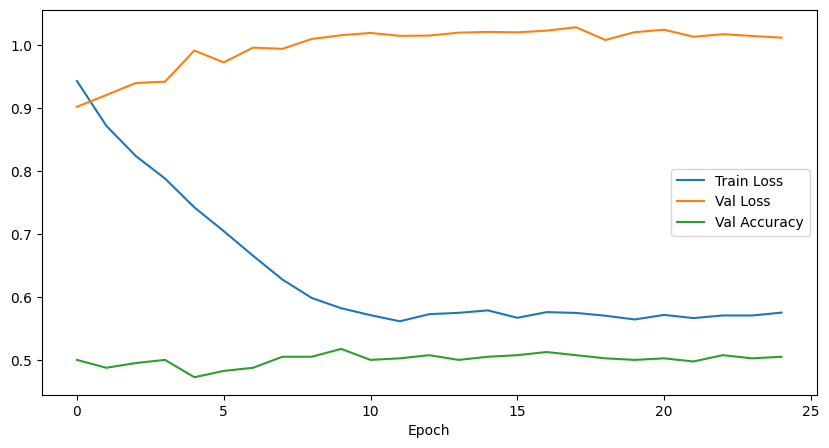

In [646]:
from torch import nn

model = nn.Sequential(
    nn.Linear(768, 1512),
    nn.BatchNorm1d(1512),
    nn.GELU(),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(1512, 256),
    nn.GELU(),
    nn.Dropout(0.2),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, NUM_LABELS)
)

model = model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

num_epochs = 10
num_warmup_steps = 10
num_training_steps = len(train_dataloader) * num_epochs
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

from torch.utils.data import Dataset, DataLoader

# 1. Create a Dataset for embeddings
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return {'input_ids': self.X[idx], 'labels': self.y[idx]}


train_y_mapped = np.array(train_y, dtype=np.int64)
test_y_mapped = np.array(test_y, dtype=np.int64)

batch_size = 16
train_dataset = EmbeddingDataset(train_x_sen_mean, train_y_mapped)
val_dataset = EmbeddingDataset(test_x_sen_mean, test_y_mapped)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


def train(model, train_loader, val_loader, optimizer, scheduler, num_epochs=10):
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
        # Validation
        model.eval()
        eval_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                logits = model(input_ids)
                loss = loss_fn(logits, labels)
                eval_loss += loss.item()
                preds = torch.argmax(logits, dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_losses.append(eval_loss / len(val_loader))
        val_accuracies.append(correct / total)
        print(f"Validation Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracies[-1]:.4f}")
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


train(model, train_loader, val_loader, optimizer, scheduler, num_epochs=25)

# Feature Creation

## Impact

In [151]:
training['Impact_idrbfe'].value_counts()

Impact_idrbfe
None        468
Positive    356
Negative    176
Name: count, dtype: int64

In [152]:
def proc_impact(impact):
    if impact == 'Positive':
        return 1
    elif impact == 'Negative':
        return -1
    else:
        return 0

In [153]:
training['Impact_idrbfe'] = training['Impact_idrbfe'].apply(proc_impact)

In [155]:
__, _, train_y, test_y = train_test_split(df['bart_summ'][:1000], training['Impact_idrbfe'], test_size=0.2, random_state=42, stratify = training['Impact_idrbfe'])

In [156]:
# mean	SVC	True	

model = SVC()

param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto']  # add if using RBF/poly/sigmoid kernels
}

grid = GridSearchCV(model, param_grid, cv = 3, scoring = 'f1_weighted', n_jobs = -1)
grid.fit(train_x_sen_mean, train_y)
best_model = grid.best_estimator_

# all_embeddings = []
# for article in tqdm(df['bart_summ']):
#     emb = get_article_embeddings_sentence(article, tokenizer, bert_model, device)
#     all_embeddings.append(get_article_embeddings_agg(emb, bert_model, agg = 'mean'))

# all_embeddings = np.array(all_embeddings)
df['impact_idrbfe'] = best_model.predict(all_embeddings)

In [157]:
all_embeddings = df['sen_emb'].tolist() 

In [158]:
# df['sen_emb'] = all_embeddings.tolist()

df_sen_mean = []
df_sen_max = []
df_sen_mix = []
df_sen_sum = []
df_sen_concat = []
df_sen_mix2 = []
for emb in all_embeddings:
    df_sen_mean.append(get_article_embeddings_agg(emb, bert_model, agg='mean'))
    df_sen_max.append(get_article_embeddings_agg(emb, bert_model, agg='max'))
    df_sen_mix.append(get_article_embeddings_agg(emb, bert_model, agg='mix'))
    df_sen_sum.append(get_article_embeddings_agg(emb, bert_model, agg='sum'))
    df_sen_concat.append(get_article_embeddings_agg(emb, bert_model, agg='concat'))
    df_sen_mix2.append(get_article_embeddings_agg(emb, bert_model, agg='mix2'))

all_embeddings = np.array(all_embeddings)
for agg in ['mean', 'max', 'mix', 'sum', 'concat', 'mix2']:
    df[f'sen_emb_{agg}'] = all_embeddings.tolist()  

In [ ]:
from datasets import Dataset
login(token="TOKEN_HERE")
dataset = Dataset.from_pandas(df)
dataset.push_to_hub('shipping_news_articles_summary_emb')

Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Ktzoras/shipping_news_articles_summary_emb/commit/20b2b3ef3d00ebcf39edfc170160adca9c51f67f', commit_message='Upload dataset', commit_description='', oid='20b2b3ef3d00ebcf39edfc170160adca9c51f67f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Ktzoras/shipping_news_articles_summary_emb', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Ktzoras/shipping_news_articles_summary_emb'), pr_revision=None, pr_num=None)

In [ ]:
# %pip install datasets huggingface_hub --quiet

# from datasets import Dataset
# from huggingface_hub import login

# login(token="TOKEN_HERE")
# dataset = Dataset.from_pandas(df)
# dataset.push_to_hub('shipping_news_articles_summary_emb')

Note: you may need to restart the kernel to use updated packages.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/41 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/506 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Ktzoras/shipping_news_articles_summary_emb/commit/a3a5412022e5a43bc912bbedb553a01deee60cbc', commit_message='Upload dataset', commit_description='', oid='a3a5412022e5a43bc912bbedb553a01deee60cbc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Ktzoras/shipping_news_articles_summary_emb', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Ktzoras/shipping_news_articles_summary_emb'), pr_revision=None, pr_num=None)

## Vesel Type

In [167]:
training['Type of Vessel_idrbfe'].value_counts()

Type of Vessel_idrbfe
0    912
1     88
Name: count, dtype: int64

In [168]:
# Vesel Type

model = LogisticRegression()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }
__, _, train_y, test_y = train_test_split(df['bart_summ'][:1000], training['Type of Vessel_idrbfe'], test_size=0.2, random_state=42, stratify = training['Type of Vessel_idrbfe'])

grid = GridSearchCV(model, param_grid, cv = 3, scoring = 'f1_weighted', n_jobs = -1)
grid.fit(train_x_sen_mean, train_y)
best_model = grid.best_estimator_

all_embeddings = np.array(all_embeddings)
df['type_idrbfe'] = best_model.predict(all_embeddings)

## Route

In [170]:
# Route

model = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
__, _, train_y, test_y = train_test_split(df['bart_summ'][:1000], training['Sea Route_idrbfe'], test_size=0.2, random_state=42, stratify = training['Sea Route_idrbfe'])

grid = GridSearchCV(model, param_grid, cv = 3, scoring = 'f1_weighted', n_jobs = -1)
grid.fit(train_x_sen_mean, train_y)
best_model = grid.best_estimator_

all_embeddings = np.array(all_embeddings)
df['route_idrbfe'] = best_model.predict(all_embeddings)

## Results

In [171]:
df['route_idrbfe'].value_counts()

route_idrbfe
None     33647
All       3360
Other     3004
C5           1
C3           1
Name: count, dtype: int64

In [172]:
df['type_idrbfe'].value_counts()

type_idrbfe
0    37342
1     2671
Name: count, dtype: int64

In [173]:
df['impact_idrbfe'].value_counts()

impact_idrbfe
 0    21564
 1    11836
-1     6613
Name: count, dtype: int64

# Relevant Subset - Weekly Features

In [181]:
subset = df[df['type_idrbfe'] == 1]
# subset = subset[subset['route_idrbfe'] == 1]

In [182]:
subset.shape

(2671, 16)

In [183]:
subset.date.value_counts()

date
2024-09-05    8
2021-03-05    7
2022-04-12    7
2024-02-02    6
2023-01-25    6
             ..
2024-05-29    1
2024-06-01    1
2022-02-16    1
2022-02-18    1
2022-02-24    1
Name: count, Length: 1287, dtype: int64

# Regression

## Preproc

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()

,Date,c5,c3
0,1-Mar-99,3.10,5.44
1,2-Mar-99,3.03,5.50
2,3-Mar-99,3.10,5.54
3,4-Mar-99,3.11,5.52
4,5-Mar-99,3.15,5.52


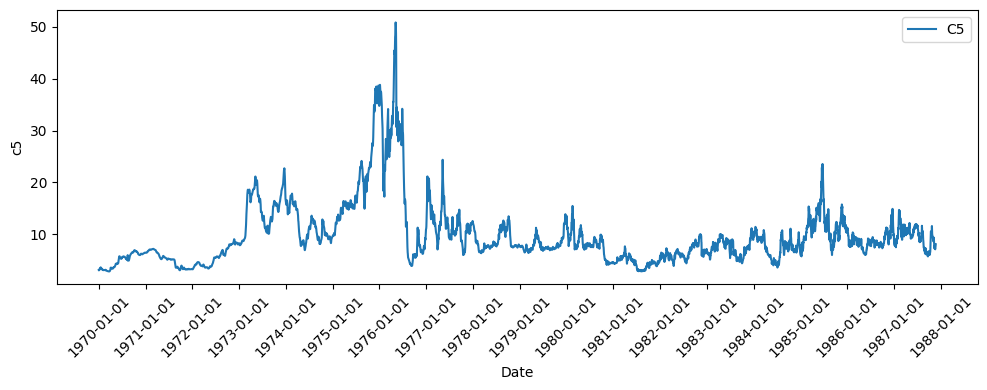

In [7]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(x=c5.Date, y=c5['c5'], label='C5', ax=ax)

# Set x-axis major ticks to every Nth date (e.g., every 10th)
N = 20
ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=N))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [185]:
type(c5.c5.iloc[0])

numpy.float64

In [ ]:
# def fix_num(num):
#   return num.replace('.', '')[:-2]


c5['Date'] = pd.to_datetime(c5['Date'], format = '%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)

In [187]:
# 1. Aggregate impact by date (mean, sum, or mode depending on your use case)
impact_by_date = subset.groupby('date')['impact_idrbfe'].mean()  # or .sum(), .mode()[0], etc.

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# 3. Add the impact feature by aligning on the index (date)
# If c5_w index is weekly, this will align impact to the closest week
c5_w_df['impact'] = impact_by_date.reindex(c5_w_df.index, method='ffill')  # or method='nearest' if preferred

# 4. (Optional) Fill missing impact values with 0 or another value if needed
c5_w_df['impact'] = c5_w_df['impact'].fillna(0)

# Now c5_w_df has both 'c5' and 'impact' columns
print(c5_w_df.head())

              c5  impact
Date                    
1999-03-07  3.11     0.0
1999-03-14  3.30     0.0
1999-03-21  3.61     0.0
1999-03-28  3.37     0.0
1999-04-04  3.35     0.0


In [188]:
# Add a column with the mean impact from the full df (not just subset)
mean_impact_by_date = df.groupby('date')['impact_idrbfe'].mean()

# Add to c5_w_df, aligning by date (forward fill for missing dates)
c5_w_df['impact_all'] = mean_impact_by_date.reindex(c5_w_df.index, method='ffill').fillna(0)

print(c5_w_df.head())

              c5  impact  impact_all
Date                                
1999-03-07  3.11     0.0         0.0
1999-03-14  3.30     0.0         0.0
1999-03-21  3.61     0.0         0.0
1999-03-28  3.37     0.0         0.0
1999-04-04  3.35     0.0         0.0


In [189]:
df.date.tail(1)

40012   2020-01-03
Name: date, dtype: datetime64[ns]

In [190]:
df.date.head(1)

0   2025-04-18
Name: date, dtype: datetime64[ns]

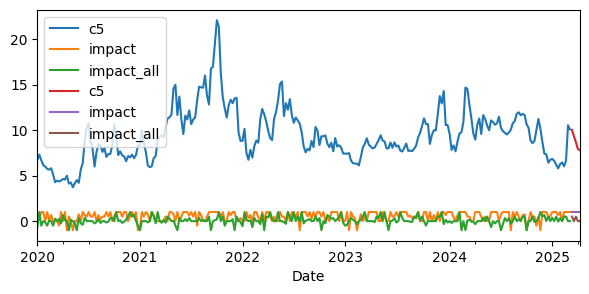

In [191]:
train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]

fig, ax = plt.subplots(figsize=(7, 3))
train.plot(ax=ax, label = "Train")
test.plot(ax=ax, label = "Test")
ax.legend()

In [192]:
window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

In [193]:
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

In [194]:
window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# Use only 'c5' and 'impact' columns as features
values = c5_w_df[['c5', 'impact']].values  # shape: (num_weeks, 2)
feature_names = ['c5', 'impact']

# Build column names: c5_t-6, impact_t-6, ..., c5_t-1, impact_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # y is only c5 (mean of next 2 weeks)
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

In [195]:
X_train.head()

,c5_t-6,impact_t-6,impact_all_t-6,c5_t-5,impact_t-5,impact_all_t-5,c5_t-4,impact_t-4,impact_all_t-4,c5_t-3,impact_t-3,impact_all_t-3,c5_t-2,impact_t-2,impact_all_t-2,c5_t-1,impact_t-1,impact_all_t-1
0,6.73,0.000000,-0.666667,7.31,0.333333,1.000,6.68,1.0,-0.500000,6.16,1.000000,0.000000,6.00,0.000000,-0.125000,5.74,1.000000,-0.500000
1,7.31,0.333333,1.000000,6.68,1.000000,-0.500,6.16,1.0,0.000000,6.00,0.000000,-0.125000,5.74,1.000000,-0.500000,5.66,0.000000,0.076923
2,6.68,1.000000,-0.500000,6.16,1.000000,0.000,6.00,0.0,-0.125000,5.74,1.000000,-0.500000,5.66,0.000000,0.076923,5.81,0.666667,0.000000
3,6.16,1.000000,0.000000,6.00,0.000000,-0.125,5.74,1.0,-0.500000,5.66,0.000000,0.076923,5.81,0.666667,0.000000,5.12,0.000000,-0.500000
4,6.00,0.000000,-0.125000,5.74,1.000000,-0.500,5.66,0.0,0.076923,5.81,0.666667,0.000000,5.12,0.000000,-0.500000,4.28,0.000000,0.266667


In [196]:
X_train_raw.head()

,c5_t-6,c5_t-5,c5_t-4,c5_t-3,c5_t-2,c5_t-1
0,6.73,7.31,6.68,6.16,6.00,5.74
1,7.31,6.68,6.16,6.00,5.74,5.66
2,6.68,6.16,6.00,5.74,5.66,5.81
3,6.16,6.00,5.74,5.66,5.81,5.12
4,6.00,5.74,5.66,5.81,5.12,4.28


In [197]:
X_train_impact.head()

,c5_t-6,impact_t-6,c5_t-5,impact_t-5,c5_t-4,impact_t-4,c5_t-3,impact_t-3,c5_t-2,impact_t-2,c5_t-1,impact_t-1
0,6.73,0.000000,7.31,0.333333,6.68,1.0,6.16,1.000000,6.00,0.000000,5.74,1.000000
1,7.31,0.333333,6.68,1.000000,6.16,1.0,6.00,0.000000,5.74,1.000000,5.66,0.000000
2,6.68,1.000000,6.16,1.000000,6.00,0.0,5.74,1.000000,5.66,0.000000,5.81,0.666667
3,6.16,1.000000,6.00,0.000000,5.74,1.0,5.66,0.000000,5.81,0.666667,5.12,0.000000
4,6.00,0.000000,5.74,1.000000,5.66,0.0,5.81,0.666667,5.12,0.000000,4.28,0.000000


## Models

In [198]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score


### Default

In [199]:
reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}

In [572]:
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []

In [573]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.957087  0.684034
1                      Ridge  Default        None  1.006722  0.667648
4                        SVR  Default        None  1.168281  0.614312
6  GradientBoostingRegressor  Default        None  1.452693  0.520418
8              LGBMRegressor  Default        None  1.531656  0.494350
5      RandomForestRegressor  Default        None  1.545222  0.489871
7               XGBRegressor  Default        None  1.651320  0.454845
3                 ElasticNet  Default        None  3.031407 -0.000768
2                      Lasso  Default        None  3.031407 -0.000768


In [574]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
4                        SVR  Default        None  0.868629  0.713237
0           LinearRegression  Default        None  0.993655  0.671962
1                      Ridge  Default        None  1.085629  0.641598
6  GradientBoostingRegressor  Default        None  1.567050  0.482665
5      RandomForestRegressor  Default        None  1.617074  0.466150
8              LGBMRegressor  Default        None  1.754859  0.420663
7               XGBRegressor  Default        None  2.071019  0.316288
3                 ElasticNet  Default        None  3.031407 -0.000768
2                      Lasso  Default        None  3.031407 -0.000768


In [575]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.961015  0.682737
1                      Ridge  Default        None  1.055752  0.651461
4                        SVR  Default        None  1.156972  0.618045
6  GradientBoostingRegressor  Default        None  1.560831  0.484718
5      RandomForestRegressor  Default        None  1.670208  0.448609
7               XGBRegressor  Default        None  1.898587  0.373214
8              LGBMRegressor  Default        None  2.130934  0.296508
3                 ElasticNet  Default        None  3.031407 -0.000768
2                      Lasso  Default        None  3.031407 -0.000768


### Optimized

In [576]:
from sklearn.model_selection import GridSearchCV

param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {'model__alpha': [0.01, 0.1, 1, 10]},
    'Lasso Regression': {'model__alpha': [0.01, 0.1, 1, 10]},
    'ElasticNet Regression': {
        'model__alpha': [0.01, 0.1, 1, 10],
        'model__l1_ratio': [0.1, 0.5, 0.9]
    },
    'SVR': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['rbf', 'linear'],
        'model__gamma': ['scale']
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    }
    # },
    # 'Gradient Boosting': {
    #     'model__n_estimators': [100, 200],
    #     'model__learning_rate': [0.01, 0.1],
    #     'model__max_depth': [3, 7],
    #     'model__min_samples_split': [2, 5],
    #     'model__min_samples_leaf': [1, 2]
    # },
    # 'XGBoost': {
    #     'model__n_estimators': [100, 200],
    #     'model__learning_rate': [0.01, 0.1],
    #     'model__max_depth': [3, 7],
    #     'model__subsample': [0.8, 1.0],
    #     'model__colsample_bytree': [0.8, 1.0]
    # },
    # 'LightGBM': {
    #     'model__n_estimators': [100, 200],
    #     'model__learning_rate': [0.01, 0.1],
    #     'model__max_depth': [7, -1],
    #     'model__num_leaves': [31, 63]
    # }
}

results = []
for name, pipe in pipelines.items():
    grid = GridSearchCV(pipe, param_grids.get(name, {}), cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((name, 'Optimized', 'all', grid.best_params_, mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Optimized', 'data', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
# print(results_df)

In [577]:
for name, pipe in pipelines.items():
    grid = GridSearchCV(pipe, param_grids.get(name, {}), cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train_raw, y_train)
    y_pred = grid.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((name, 'Optimized', 'raw', grid.best_params_, mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Optimized', 'data', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)

In [578]:
for name, pipe in pipelines.items():
    grid = GridSearchCV(pipe, param_grids.get(name, {}), cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train_impact, y_train)
    y_pred = grid.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((name, 'Optimized', 'impact', grid.best_params_, mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Optimized', 'data', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)

In [579]:
results_df

,Model,Optimized,data,Best Params,MSE,R2
4,SVR,Optimized,all,"{'model__C': 10, 'model__gamma': 'scale', 'mod...",0.911087,0.699220
2,Lasso Regression,Optimized,all,{'model__alpha': 0.01},0.936972,0.690674
22,SVR,Optimized,impact,"{'model__C': 10, 'model__gamma': 'scale', 'mod...",0.938952,0.690021
13,SVR,Optimized,raw,"{'model__C': 10, 'model__gamma': 'scale', 'mod...",0.940578,0.689484
3,ElasticNet Regression,Optimized,all,"{'model__alpha': 0.01, 'model__l1_ratio': 0.9}",0.952637,0.685503
1,Ridge Regression,Optimized,all,{'model__alpha': 0.01},0.953420,0.685245
0,Linear Regression,Optimized,all,{},0.957087,0.684034
10,Ridge Regression,Optimized,raw,{'model__alpha': 0.01},0.959150,0.683353
9,Linear Regression,Optimized,raw,{},0.961015,0.682737
11,Lasso Regression,Optimized,raw,{'model__alpha': 0.01},0.983478,0.675321


## Significance

In [580]:
import statsmodels.api as sm

# Example for X_train_impact and y_train
X_sm = sm.add_constant(X_train_impact)  # Adds intercept term
model = sm.OLS(y_train, X_sm)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     70.47
Date:                Tue, 27 May 2025   Prob (F-statistic):           2.22e-65
Time:                        08:03:40   Log-Likelihood:                -362.15
No. Observations:                 215   AIC:                             750.3
Df Residuals:                     202   BIC:                             794.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9883      0.335      2.952      0.0

In [590]:
import numpy as np
import pandas as pd
from scipy import stats

def sklearn_linear_model_significance(model, X, y):
    """
    Calculate t-statistics and p-values for sklearn linear regression models.
    Args:
        model: Fitted sklearn linear model (e.g., LinearRegression, Ridge)
        X: Features used for fitting (numpy array or DataFrame)
        y: Target variable (numpy array or Series)
    Returns:
        DataFrame with coefficients, std errors, t-stats, and p-values
    """
    # Save column names if X is a DataFrame
    if hasattr(X, "columns"):
        colnames = list(X.columns)
        X_vals = X.values
    else:
        colnames = [f'x{i}' for i in range(X.shape[1])]
        X_vals = X
    n, k = X_vals.shape
    X_ = np.column_stack([np.ones(n), X_vals])  # add intercept
    y_pred = model.predict(X_vals)
    residuals = y - y_pred
    dof = n - k - 1
    mse = np.sum(residuals ** 2) / dof
    var_b = mse * np.linalg.inv(X_.T @ X_).diagonal()
    std_b = np.sqrt(var_b)
    params = np.append(model.intercept_, model.coef_)
    t_stats = params / std_b
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), dof))
    columns = ['Intercept'] + colnames
    return pd.DataFrame({
        'coef': params,
        'std_err': std_b,
        't': t_stats,
        'p': p_values
    }, index=columns)

model = LinearRegression().fit(X_train, y_train)
summary = sklearn_linear_model_significance(model, X_train, y_train)
print(summary)

                    coef   std_err          t         p
Intercept       0.983254  0.336390   2.922958  0.003875
c5_t-6          0.200139  0.081484   2.456161  0.014914
impact_t-6      0.366332  0.391320   0.936147  0.350350
impact_all_t-6 -0.176116  0.224386  -0.784876  0.433474
c5_t-5          0.071911  0.113170   0.635429  0.525890
impact_t-5     -0.238760  0.516837  -0.461964  0.644620
impact_all_t-5  0.076306  0.223628   0.341217  0.733306
c5_t-4         -0.189121  0.112146  -1.686381  0.093313
impact_t-4     -0.068705  0.520514  -0.131994  0.895124
impact_all_t-4  0.193720  0.227290   0.852300  0.395088
c5_t-3         -0.114062  0.110164  -1.035389  0.301763
impact_t-3     -0.118635  0.520556  -0.227900  0.819961
impact_all_t-3 -0.013986  0.223802  -0.062493  0.950234
c5_t-2         -0.011619  0.110479  -0.105174  0.916346
impact_t-2      0.210086  0.516621   0.406655  0.684705
impact_all_t-2 -0.363118  0.220651  -1.645662  0.101436
c5_t-1          0.947111  0.079258  11.949755  0

In [582]:
from statsmodels.tsa.stattools import grangercausalitytests

# Example: test if 'impact' Granger-causes 'c5'
# maxlag: number of lags to test
data = c5_w_df[['c5', 'impact']].dropna()
grangercausalitytests(data[['c5', 'impact']], maxlag=8, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5380  , p=0.2160  , df_denom=272, df_num=1
ssr based chi2 test:   chi2=1.5550  , p=0.2124  , df=1
likelihood ratio test: chi2=1.5506  , p=0.2131  , df=1
parameter F test:         F=1.5380  , p=0.2160  , df_denom=272, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7451  , p=0.4757  , df_denom=269, df_num=2
ssr based chi2 test:   chi2=1.5178  , p=0.4682  , df=2
likelihood ratio test: chi2=1.5136  , p=0.4692  , df=2
parameter F test:         F=0.7451  , p=0.4757  , df_denom=269, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6385  , p=0.5908  , df_denom=266, df_num=3
ssr based chi2 test:   chi2=1.9658  , p=0.5795  , df=3
likelihood ratio test: chi2=1.9588  , p=0.5810  , df=3
parameter F test:         F=0.6385  , p=0.5908  , df_denom=266, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5353  , p=0.7099  

{np.int64(1): ({'ssr_ftest': (np.float64(1.5379875182092793),
    np.float64(0.2159863642481619),
    np.float64(272.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.5549506158365876),
    np.float64(0.21240608144155865),
    np.int64(1)),
   'lrtest': (np.float64(1.5505709875775437),
    np.float64(0.21305116744375363),
    np.int64(1)),
   'params_ftest': (np.float64(1.5379875182093306),
    np.float64(0.21598636424814627),
    np.float64(272.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.7450646421691409),
    np.float64(0.47568063553185624),
    np.float64(269.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(1.517826854679142),
    np.float64(0.4681748567365964),
    np.int64(2)),
   'lrtest': (np.float64(1.5136383043080741),
    np.float64(0.46915637114344144),
    np.int64(2)),
   'params_ftest': (np.float64(0.7450646421691782),
    np.float64(0.47568063553184203),
    np.float64(269.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
 

In [583]:
from statsmodels.tsa.stattools import grangercausalitytests

# Example: test if 'impact' Granger-causes 'c5'
# maxlag: number of lags to test
data = c5_w_df[['c5', 'impact_all']].dropna()
grangercausalitytests(data[['c5', 'impact_all']], maxlag=8, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0171  , p=0.8960  , df_denom=272, df_num=1
ssr based chi2 test:   chi2=0.0173  , p=0.8954  , df=1
likelihood ratio test: chi2=0.0173  , p=0.8954  , df=1
parameter F test:         F=0.0171  , p=0.8960  , df_denom=272, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3787  , p=0.0946  , df_denom=269, df_num=2
ssr based chi2 test:   chi2=4.8459  , p=0.0887  , df=2
likelihood ratio test: chi2=4.8035  , p=0.0906  , df=2
parameter F test:         F=2.3787  , p=0.0946  , df_denom=269, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9130  , p=0.1278  , df_denom=266, df_num=3
ssr based chi2 test:   chi2=5.8901  , p=0.1171  , df=3
likelihood ratio test: chi2=5.8275  , p=0.1203  , df=3
parameter F test:         F=1.9130  , p=0.1278  , df_denom=266, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3626  , p=0.2473  

{np.int64(1): ({'ssr_ftest': (np.float64(0.01710222444216964),
    np.float64(0.8960495943447542),
    np.float64(272.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.017290851917634745),
    np.float64(0.8953839916233136),
    np.int64(1)),
   'lrtest': (np.float64(0.017290308352016837),
    np.float64(0.8953856265664789),
    np.int64(1)),
   'params_ftest': (np.float64(0.01710222444210144),
    np.float64(0.8960495943449367),
    np.float64(272.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(2.3787235398541826),
    np.float64(0.09461553143254856),
    np.float64(269.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(4.845875464089561),
    np.float64(0.08866077290759798),
    np.int64(2)),
   'lrtest': (np.float64(4.803522798219433),
    np.float64(0.0905583034121056),
    np.int64(2)),
   'params_ftest': (np.float64(2.3787235398541506),
    np.float64(0.09461553143255146),
    np.float64(269.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],

In [584]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = X_train_impact.values if hasattr(X_train_impact, "values") else X_train_impact
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif)

[np.float64(70.71826921718763), np.float64(6.25027592657709), np.float64(139.3349038341136), np.float64(11.08091946370306), np.float64(136.44454562348977), np.float64(11.328843025206385), np.float64(135.1366053909513), np.float64(11.465124068011592), np.float64(137.2769570628327), np.float64(11.250000076654961), np.float64(69.05142769087747), np.float64(6.292278063073684)]


### Reverse Causality

In [585]:
from statsmodels.tsa.stattools import grangercausalitytests

# Test if c5 Granger-causes impact
data_rev = c5_w_df[['impact', 'c5']].dropna()
print("Does c5 Granger-cause impact?")
grangercausalitytests(data_rev[['impact', 'c5']], maxlag=8, verbose=True)

# Test if c5 Granger-causes impact_all
data_rev_all = c5_w_df[['impact_all', 'c5']].dropna()
print("Does c5 Granger-cause impact_all?")
grangercausalitytests(data_rev_all[['impact_all', 'c5']], maxlag=8, verbose=True)

Does c5 Granger-cause impact?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7776  , p=0.0169  , df_denom=272, df_num=1
ssr based chi2 test:   chi2=5.8413  , p=0.0157  , df=1
likelihood ratio test: chi2=5.7801  , p=0.0162  , df=1
parameter F test:         F=5.7776  , p=0.0169  , df_denom=272, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3146  , p=0.0143  , df_denom=269, df_num=2
ssr based chi2 test:   chi2=8.7896  , p=0.0123  , df=2
likelihood ratio test: chi2=8.6516  , p=0.0132  , df=2
parameter F test:         F=4.3146  , p=0.0143  , df_denom=269, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6707  , p=0.0128  , df_denom=266, df_num=3
ssr based chi2 test:   chi2=11.3018 , p=0.0102  , df=3
likelihood ratio test: chi2=11.0741 , p=0.0113  , df=3
parameter F test:         F=3.6707  , p=0.0128  , df_denom=266, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test: 

{np.int64(1): ({'ssr_ftest': (np.float64(0.2575085023894357),
    np.float64(0.6122482352409673),
    np.float64(272.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.26034866969520154),
    np.float64(0.6098807152232489),
    np.int64(1)),
   'lrtest': (np.float64(0.2602255084588023),
    np.float64(0.6099652698103328),
    np.int64(1)),
   'params_ftest': (np.float64(0.2575085023894416),
    np.float64(0.6122482352409673),
    np.float64(272.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.14389785129244506),
    np.float64(0.866042816483891),
    np.float64(269.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(0.29314506508646804),
    np.float64(0.863663086382702),
    np.int64(2)),
   'lrtest': (np.float64(0.29298836292230135),
    np.float64(0.863730757971112),
    np.int64(2)),
   'params_ftest': (np.float64(0.1438978512924796),
    np.float64(0.8660428164838652),
    np.float64(269.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
     

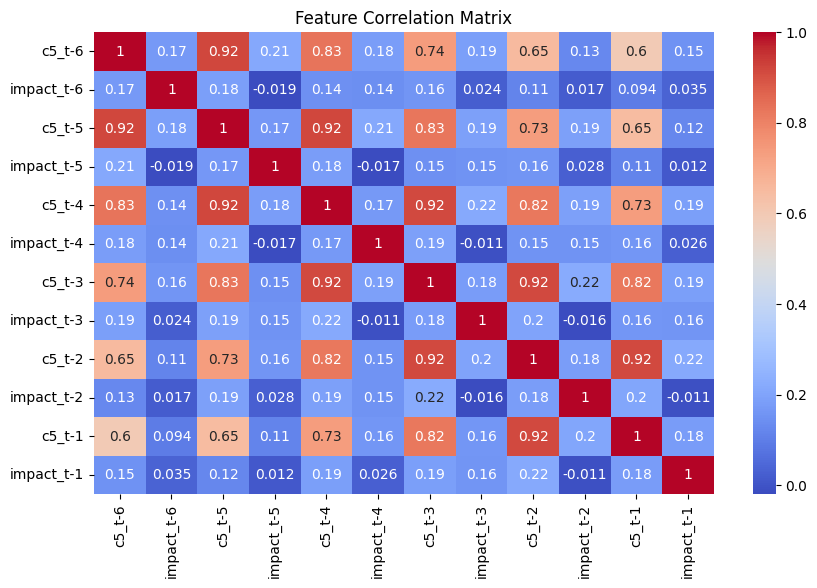

In [231]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X_train_impact.corr() if hasattr(X_train_impact, "corr") else pd.DataFrame(X_train_impact).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

### Toda-Yamamoto Causality Test

In [230]:
from statsmodels.tsa.vector_ar.var_model import VAR

# Prepare data
data_var = c5_w_df[['c5', 'impact', 'impact_all']].dropna()
model = VAR(data_var)
results = model.fit(maxlags=4, ic='aic')

# Test causality
print(results.test_causality('c5', ['impact', 'impact_all'], kind='f'))
print(results.test_causality('impact', ['c5'], kind='f'))
print(results.test_causality('impact_all', ['c5'], kind='f'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: ['impact', 'impact_all'] do not Granger-cause c5: fail to reject at 5% significance level. Test statistic: 1.952, critical value: 3.007>, p-value: 0.143>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: c5 does not Granger-cause impact: reject at 5% significance level. Test statistic: 5.003, critical value: 3.853>, p-value: 0.026>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: c5 does not Granger-cause impact_all: fail to reject at 5% significance level. Test statistic: 0.222, critical value: 3.853>, p-value: 0.638>


### Transfer Entropy 

In [202]:
import pyinform.transferentropy as te

In [204]:
# Discretize your data if needed
c5_disc = (c5_w_df['c5'] * 10).astype(int).values
impact_disc = (c5_w_df['impact_all'] * 10).astype(int).values

# Calculate transfer entropy: impact → c5
te_val = te.transfer_entropy(np.abs(impact_disc), c5_disc, k=1)
print("Transfer Entropy (impact_all → c5):", te_val) 

Transfer Entropy (impact_all → c5): 1.110606575399956


In [207]:
impact_disc = (c5_w_df['impact_all'] * 10).astype(int).values
max_lag = 10  # Set the maximum lag you want to test
for lag in range(1, max_lag + 1):
    # Shift impact_disc by lag
    impact_lagged = np.roll(np.abs(impact_disc), lag)
    # Set the first 'lag' elements to np.nan or a neutral value to avoid leakage
    impact_lagged[:lag] = 0  # or np.nan if your TE implementation handles it

    # Calculate transfer entropy: lagged impact → c5
    te_val = te.transfer_entropy(impact_lagged, c5_disc, k=1)
    print(f"Transfer Entropy (impact_all_t-{lag} → c5):", te_val)

Transfer Entropy (impact_all_t-1 → c5): 1.1649870060995318
Transfer Entropy (impact_all_t-2 → c5): 1.120624348135098
Transfer Entropy (impact_all_t-3 → c5): 1.1203882333486574
Transfer Entropy (impact_all_t-4 → c5): 1.1923892117478585
Transfer Entropy (impact_all_t-5 → c5): 1.081373484427928
Transfer Entropy (impact_all_t-6 → c5): 1.1386411424710359
Transfer Entropy (impact_all_t-7 → c5): 1.1655862680500062
Transfer Entropy (impact_all_t-8 → c5): 1.1795324606449866
Transfer Entropy (impact_all_t-9 → c5): 1.1109697225639927
Transfer Entropy (impact_all_t-10 → c5): 1.1263354043428384


Predictive Power: There is a nonzero, moderate information flow from past impact_all to c5. This suggests that past impact events (as measured by your impact_all variable) contain information that helps predict future values of c5.
No Dominant Lag: No single lag dominates, so the relationship is not sharply peaked at a particular time delay. This could mean the effect of impact_all on c5 is spread out or that the system is influenced by a combination of recent weeks.

In [ ]:
# Discretize if needed
impact_disc = (c5_w_df['impact'] * 10).astype(int).values
c5_disc = (c5_w_df['c5'] * 10).astype(int).values

# Calculate transfer entropy: c5 → impact
te_val_rev = te.transfer_entropy(c5_disc, impact_disc, k=1)
print("Transfer Entropy (c5 → impact):", te_val_rev)

Transfer Entropy (c5 → impact): 0.1874139133351016


### Convergent Cross Mapping (CCM)

CCM (impact_all → c5):
         impact_all:c5
LibSize               
10           -0.002750
20           -0.006611
30           -0.007308
40           -0.002102
50            0.000555
60            0.004863
70           -0.000791
80            0.004986
90            0.005964
100           0.015182
110           0.007343
120           0.013091
130           0.024239
140           0.010035
150           0.020491
160           0.023679
170           0.021135
180           0.026034
190           0.032396
200           0.038710
210           0.036347
220           0.041986
230           0.044759
240           0.042782
250           0.046990
260           0.048970
270           0.055844
CCM (c5 → impact_all):
         c5:impact_all
LibSize               
10           -0.024662
20           -0.031732
30           -0.041185
40           -0.058552
50           -0.059067
60           -0.064194
70           -0.062775
80           -0.073964
90           -0.074054
100          -0.074248
110        

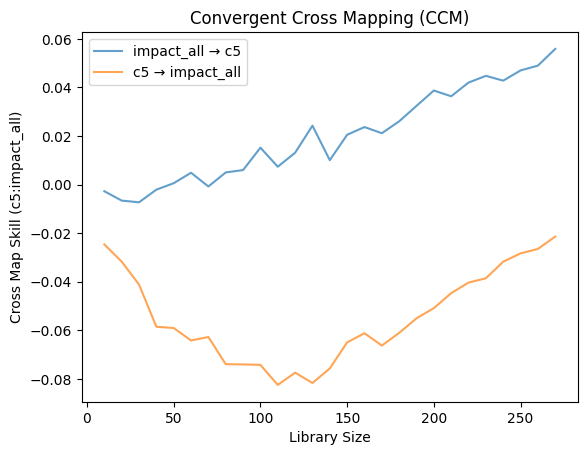

In [216]:
import pandas as pd
import numpy as np
from pyEDM import CCM

# Prepare your time series (must be pandas Series with no missing values)
# Example: use weekly data, dropna to ensure no missing values
c5_series = c5_w_df['c5'].reset_index(drop=True)
impact_series = c5_w_df['impact_all'].reset_index(drop=True)

# CCM requires a DataFrame with columns named for each variable
df_ccm = pd.DataFrame({
    'c5': c5_series,
    'impact_all': impact_series
})

# Run CCM: test if impact_all causes c5
ccm_result = CCM(
    dataFrame=df_ccm,
    E=2,
    columns='impact_all',
    target='c5',
    libSizes=np.arange(10, len(df_ccm), 10),
    sample=100
)
print("CCM (impact_all → c5):")
print(ccm_result[['LibSize', 'impact_all:c5']].groupby('LibSize').mean())

# Run CCM: test if c5 causes impact_all
ccm_result_rev = CCM(
    dataFrame=df_ccm,
    E=2,
    columns='c5',
    target='impact_all',
    libSizes=np.arange(10, len(df_ccm), 10),
    sample=100
)
print("CCM (c5 → impact_all):")
print(ccm_result_rev[['LibSize', 'c5:impact_all']].groupby('LibSize').mean())

# Plotting CCM results
plt.plot(ccm_result['LibSize'], ccm_result['impact_all:c5'], label='impact_all → c5', alpha=0.7)
plt.plot(ccm_result_rev['LibSize'], ccm_result_rev['c5:impact_all'], label='c5 → impact_all', alpha=0.7)
plt.xlabel('Library Size')
plt.ylabel('Cross Map Skill (c5:impact_all)')
plt.legend()
plt.title('Convergent Cross Mapping (CCM)')
plt.show()

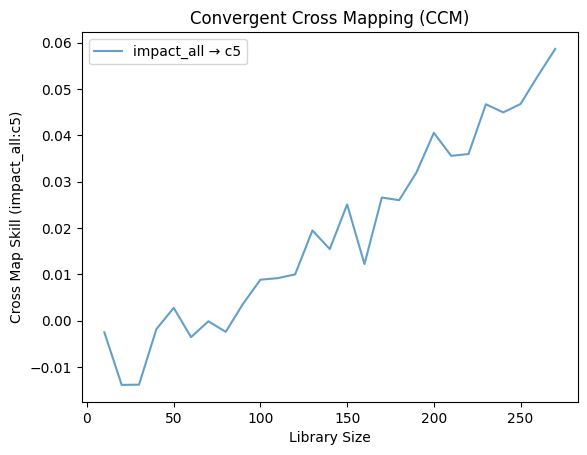

In [215]:
plt.plot(ccm_result['LibSize'], ccm_result['impact_all:c5'], label='impact_all → c5', alpha=0.7)
plt.xlabel('Library Size')
plt.ylabel('Cross Map Skill (impact_all:c5)')
plt.legend()
plt.title('Convergent Cross Mapping (CCM)')
plt.show()

###  Pearson/Spearman/Lagged Correlation

In [218]:
# Lagged correlation: impact_all (t-lag) vs c5 (t)
max_lag = 10
for lag in range(1, max_lag+1):
    corr = c5_w_df['c5'].corr(c5_w_df['impact_all'].shift(lag))
    print(f"Lag {lag}: Corr(c5, impact_all_t-{lag}) = {corr:.3f}")

Lag 1: Corr(c5, impact_all_t-1) = 0.001
Lag 2: Corr(c5, impact_all_t-2) = -0.011
Lag 3: Corr(c5, impact_all_t-3) = 0.010
Lag 4: Corr(c5, impact_all_t-4) = 0.011
Lag 5: Corr(c5, impact_all_t-5) = -0.000
Lag 6: Corr(c5, impact_all_t-6) = 0.005
Lag 7: Corr(c5, impact_all_t-7) = -0.025
Lag 8: Corr(c5, impact_all_t-8) = -0.023
Lag 9: Corr(c5, impact_all_t-9) = -0.038
Lag 10: Corr(c5, impact_all_t-10) = -0.035


### PCMCI (Causal Discovery for Time Series)

In [226]:
from tigramite.independence_tests.parcorr import ParCorr
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI

# Prepare data: shape (time, variables)
data = c5_w_df[['c5', 'impact_all']].values
dataframe = pp.DataFrame(data)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr())
results = pcmci.run_pcmci(tau_max=6, pc_alpha=0.05)
print(results['p_matrix'])  # p-values for each lag and variable

[[[1.00000000e+00 1.48748178e-41 4.14008894e-01 4.20744280e-01
   2.25456402e-03 9.42667348e-03 8.25748663e-01]
  [9.44583312e-01 4.00504616e-01 2.95358120e-01 7.80456792e-01
   3.99599545e-01 1.16632022e-01 5.11291089e-01]]

 [[9.44583312e-01 1.84176883e-01 5.64355303e-01 5.86342445e-01
   9.45988066e-01 5.69767391e-01 9.63681683e-01]
  [1.00000000e+00 9.69471534e-01 1.03147555e-01 1.11895452e-01
   8.24970097e-01 9.55347605e-01 3.09197770e-01]]]


In [227]:
import numpy as np
import pandas as pd

# Assume results['p_matrix'] is your output and variable names are:
var_names = ['c5', 'impact_all']
p_matrix = results['p_matrix']

# Set significance threshold
alpha = 0.05

# Collect significant links
sig_links = []
for effect in range(p_matrix.shape[0]):
    for cause in range(p_matrix.shape[1]):
        for lag in range(1, p_matrix.shape[2]):  # skip lag 0 (contemporaneous)
            pval = p_matrix[effect, cause, lag]
            if pval < alpha:
                sig_links.append({
                    'effect': var_names[effect],
                    'cause': var_names[cause],
                    'lag': lag,
                    'p-value': pval
                })

# Display as DataFrame
sig_df = pd.DataFrame(sig_links)
print("Significant PCMCI links (p < 0.05):")
print(sig_df)

Significant PCMCI links (p < 0.05):
  effect cause  lag       p-value
0     c5    c5    1  1.487482e-41
1     c5    c5    4  2.254564e-03
2     c5    c5    5  9.426673e-03


### Variance Inflation Factor (VIF) - multicollinearity 

In [229]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = X_train_impact.values if hasattr(X_train_impact, "values") else X_train_impact
vif_data = []
feature_names = X_train_impact.columns if hasattr(X_train_impact, "columns") else [f"x{i}" for i in range(X.shape[1])]
for i in range(X.shape[1]):
    vif_data.append({
        "feature": feature_names[i],
        "VIF": variance_inflation_factor(X, i)
    })
vif_df = pd.DataFrame(vif_data)
print(vif_df)

       feature         VIF
0       c5_t-6   73.681823
1   impact_t-6    2.161719
2       c5_t-5  149.688691
3   impact_t-5    2.276269
4       c5_t-4  142.037878
5   impact_t-4    2.290594
6       c5_t-3  139.061632
7   impact_t-3    2.289537
8       c5_t-2  144.374738
9   impact_t-2    2.293591
10      c5_t-1   69.011413
11  impact_t-1    2.305812


### Eigenvalues of the Feature Matrix

Multicollinearity can inflate standard errors, make feature importance unreliable, and reduce model interpretability.

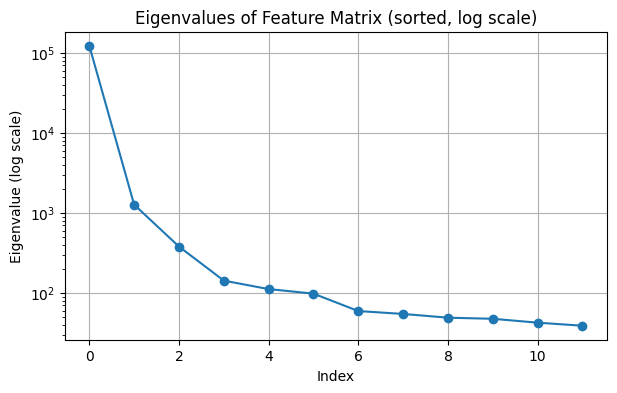

Largest eigenvalue: 1.24e+05
Smallest eigenvalue: 3.90e+01
Condition number (max/min): 3.16e+03
Eigenvalues < 1e-6: 0


In [233]:
# Compute eigenvalues
X = X_train_impact.values if hasattr(X_train_impact, "values") else X_train_impact
eigvals = np.linalg.eigvals(X.T @ X)
eigvals_sorted = np.sort(np.abs(eigvals))[::-1]

# Plot eigenvalues (log scale)
plt.figure(figsize=(7,4))
plt.plot(eigvals_sorted, marker='o')
plt.yscale('log')
plt.title("Eigenvalues of Feature Matrix (sorted, log scale)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue (log scale)")
plt.grid(True)
plt.show()

# Print summary statistics
print("Largest eigenvalue: {:.2e}".format(eigvals_sorted[0]))
print("Smallest eigenvalue: {:.2e}".format(eigvals_sorted[-1]))
print("Condition number (max/min): {:.2e}".format(eigvals_sorted[0]/eigvals_sorted[-1]))
print("Eigenvalues < 1e-6:", np.sum(eigvals_sorted < 1e-6))

## MAs

In [623]:
window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

# Calculate moving averages
ma_52 = pd.Series(c5_w).rolling(window=52, min_periods=1).mean().values
ma_26 = pd.Series(c5_w).rolling(window=26, min_periods=1).mean().values
ma_10 = pd.Series(c5_w).rolling(window=10, min_periods=1).mean().values
ma_5  = pd.Series(c5_w).rolling(window=5, min_periods=1).mean().values

X = []
y = []

values = c5_w.values  # or c5_w.to_numpy() if c5_w is a Series

for i in range(len(values) - window_size - forecast_horizon + 1):
    # Base features: previous 6 weeks
    features = list(values[i:i+window_size])
    # Add moving averages at the prediction point (i+window_size-1)
    features.append(ma_52[i+window_size-1])
    features.append(ma_26[i+window_size-1])
    features.append(ma_10[i+window_size-1])
    features.append(ma_5[i+window_size-1])
    X.append(features)
    # Predict the mean of the next 2 weeks
    y.append(values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [627]:
X_train

array([[3.1       , 3.03      , 3.1       , ..., 3.1       , 3.1       ,
        3.1       ],
       [3.03      , 3.1       , 3.11      , ..., 3.10142857, 3.10142857,
        3.116     ],
       [3.1       , 3.11      , 3.15      , ..., 3.1025    , 3.1025    ,
        3.118     ],
       ...,
       [6.16      , 6.16      , 6.16      , ..., 6.64846154, 6.143     ,
        6.108     ],
       [6.16      , 6.16      , 6.06      , ..., 6.62038462, 6.118     ,
        6.076     ],
       [6.16      , 6.06      , 6.04      , ..., 6.59653846, 6.102     ,
        6.044     ]], shape=(7639, 10))

In [626]:
results = []
for name, pipe in pipelines.items():
    grid = GridSearchCV(pipe, param_grids.get(name, {}), cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((name, 'Optimized_mas', grid.best_params_, mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Optimized', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                   Model      Optimized  \
4                    SVR  Optimized_mas   
2       Lasso Regression  Optimized_mas   
5          Random Forest  Optimized_mas   
6      Gradient Boosting  Optimized_mas   
1       Ridge Regression  Optimized_mas   
8               LightGBM  Optimized_mas   
0      Linear Regression  Optimized_mas   
7                XGBoost  Optimized_mas   
3  ElasticNet Regression  Optimized_mas   

                                         Best Params       MSE        R2  
4  {'model__C': 10, 'model__gamma': 'scale', 'mod...  0.220115  0.972331  
2                             {'model__alpha': 0.01}  0.222420  0.972041  
5  {'model__max_depth': 10, 'model__min_samples_l...  0.227703  0.971377  
6                                                 {}  0.228750  0.971245  
1                             {'model__alpha': 0.01}  0.229253  0.971182  
8                                                 {}  0.231560  0.970892  
0                                           

In [629]:
for name, pipe in pipelines.items():
    grid = GridSearchCV(pipe, param_grids.get(name, {}), cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train_impact, y_train)
    y_pred = grid.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((name, 'Optimized_mas', grid.best_params_, mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Optimized', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

ValueError: Found input variables with inconsistent numbers of samples: [1540, 7639]

In [628]:
results_df

,Model,Optimized,Best Params,MSE,R2
4,SVR,Optimized_mas,"{'model__C': 10, 'model__gamma': 'scale', 'mod...",0.220115,0.972331
2,Lasso Regression,Optimized_mas,{'model__alpha': 0.01},0.222420,0.972041
5,Random Forest,Optimized_mas,"{'model__max_depth': 10, 'model__min_samples_l...",0.227703,0.971377
6,Gradient Boosting,Optimized_mas,{},0.228750,0.971245
1,Ridge Regression,Optimized_mas,{'model__alpha': 0.01},0.229253,0.971182
8,LightGBM,Optimized_mas,{},0.231560,0.970892
0,Linear Regression,Optimized_mas,{},0.237677,0.970123
7,XGBoost,Optimized_mas,{},0.242188,0.969556
3,ElasticNet Regression,Optimized_mas,"{'model__alpha': 0.01, 'model__l1_ratio': 0.9}",0.442516,0.944374


# Regression Daily

### Preproc

In [591]:
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()

,Date,c5,c3
0,1-Mar-99,3.10,5.44
1,2-Mar-99,3.03,5.50
2,3-Mar-99,3.10,5.54
3,4-Mar-99,3.11,5.52
4,5-Mar-99,3.15,5.52


In [592]:
# def fix_num(num):
#   return num.replace('.', '')[:-2]


c5['Date'] = pd.to_datetime(c5['Date'], format='%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('d', method='bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)

In [593]:
# 1. Aggregate impact by date (mean, sum, or mode depending on your use case)
impact_by_date = subset.groupby('date')['impact_idrbfe'].mean()  # or .sum(), .mode()[0], etc.

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# 3. Add the impact feature by aligning on the index (date)
# If c5_w index is weekly, this will align impact to the closest week
c5_w_df['impact'] = impact_by_date.reindex(c5_w_df.index, method='ffill')  # or method='nearest' if preferred

# 4. (Optional) Fill missing impact values with 0 or another value if needed
c5_w_df['impact'] = c5_w_df['impact'].fillna(0)

# Now c5_w_df has both 'c5' and 'impact' columns
print(c5_w_df.head())

              c5  impact
Date                    
1999-03-01  3.10     0.0
1999-03-02  3.03     0.0
1999-03-03  3.10     0.0
1999-03-04  3.11     0.0
1999-03-05  3.15     0.0


In [594]:
# Add a column with the mean impact from the full df (not just subset)
mean_impact_by_date = df.groupby('date')['impact_idrbfe'].mean()

# Add to c5_w_df, aligning by date (forward fill for missing dates)
c5_w_df['impact_all'] = mean_impact_by_date.reindex(c5_w_df.index, method='ffill').fillna(0)

print(c5_w_df.head())

              c5  impact  impact_all
Date                                
1999-03-01  3.10     0.0         0.0
1999-03-02  3.03     0.0         0.0
1999-03-03  3.10     0.0         0.0
1999-03-04  3.11     0.0         0.0
1999-03-05  3.15     0.0         0.0


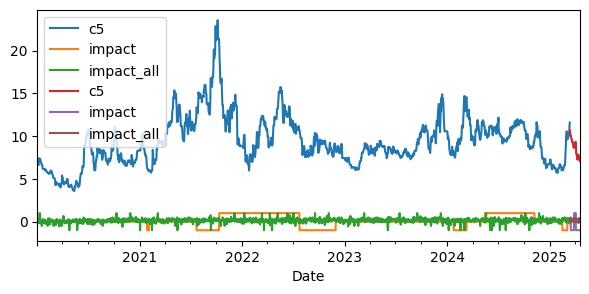

In [595]:
train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]

fig, ax = plt.subplots(figsize=(7, 3))
train.plot(ax=ax, label = "Train")
test.plot(ax=ax, label = "Test")
ax.legend()

In [596]:
window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

In [597]:
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

In [598]:
window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# Use only 'c5' and 'impact' columns as features
values = c5_w_df[['c5', 'impact']].values  # shape: (num_weeks, 2)
feature_names = ['c5', 'impact']

# Build column names: c5_t-6, impact_t-6, ..., c5_t-1, impact_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # y is only c5 (mean of next 2 weeks)
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

### Runs

In [599]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.140215  0.956136
6  GradientBoostingRegressor  Default        None  0.149696  0.953170
1                      Ridge  Default        None  0.170487  0.946665
5      RandomForestRegressor  Default        None  0.181623  0.943182
8              LGBMRegressor  Default        None  0.210562  0.934128
7               XGBRegressor  Default        None  0.215218  0.932672
4                        SVR  Default        None  0.224364  0.929811
3                 ElasticNet  Default        None  3.196774 -0.000068
2                      Lasso  Default        None  3.196774 -0.000068


In [600]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.140409  0.956075
6  GradientBoostingRegressor  Default        None  0.155842  0.951247
1                      Ridge  Default        None  0.170743  0.946585
5      RandomForestRegressor  Default        None  0.191213  0.940182
8              LGBMRegressor  Default        None  0.198452  0.937917
7               XGBRegressor  Default        None  0.202776  0.936564
4                        SVR  Default        None  0.226816  0.929044
3                 ElasticNet  Default        None  3.196774 -0.000068
2                      Lasso  Default        None  3.196774 -0.000068


In [601]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.134109  0.958046
4                        SVR  Default        None  0.136841  0.957191
6  GradientBoostingRegressor  Default        None  0.157847  0.950620
1                      Ridge  Default        None  0.157909  0.950600
5      RandomForestRegressor  Default        None  0.189075  0.940850
8              LGBMRegressor  Default        None  0.205432  0.935733
7               XGBRegressor  Default        None  0.209757  0.934380
3                 ElasticNet  Default        None  3.196774 -0.000068
2                      Lasso  Default        None  3.196774 -0.000068


### Diagnostics

In [603]:
import statsmodels.api as sm

# Example for X_train_impact and y_train
X_sm = sm.add_constant(X_train)  # Adds intercept term
model = sm.OLS(y_train, X_sm)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     3302.
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        08:17:27   Log-Likelihood:                -1050.5
No. Observations:                1540   AIC:                             2139.
Df Residuals:                    1521   BIC:                             2240.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1461      0.041      3.

In [604]:
data = c5_w_df[['c5', 'impact_all']].dropna()
grangercausalitytests(data[['c5', 'impact_all']], maxlag=8, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8601  , p=0.1728  , df_denom=1929, df_num=1
ssr based chi2 test:   chi2=1.8630  , p=0.1723  , df=1
likelihood ratio test: chi2=1.8621  , p=0.1724  , df=1
parameter F test:         F=1.8601  , p=0.1728  , df_denom=1929, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7861  , p=0.1679  , df_denom=1926, df_num=2
ssr based chi2 test:   chi2=3.5814  , p=0.1668  , df=2
likelihood ratio test: chi2=3.5781  , p=0.1671  , df=2
parameter F test:         F=1.7861  , p=0.1679  , df_denom=1926, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3638  , p=0.2521  , df_denom=1923, df_num=3
ssr based chi2 test:   chi2=4.1062  , p=0.2502  , df=3
likelihood ratio test: chi2=4.1018  , p=0.2507  , df=3
parameter F test:         F=1.3638  , p=0.2521  , df_denom=1923, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0040  , p=0.

{np.int64(1): ({'ssr_ftest': (np.float64(1.8601131919516694),
    np.float64(0.17277085724880858),
    np.float64(1929.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.8630060585021386),
    np.float64(0.17227825856909423),
    np.int64(1)),
   'lrtest': (np.float64(1.8621083975385773),
    np.float64(0.172381658069427),
    np.int64(1)),
   'params_ftest': (np.float64(1.8601131919507157),
    np.float64(0.1727708572489435),
    np.float64(1929.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.7860825796660809),
    np.float64(0.16789301882321292),
    np.float64(1926.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(3.5814386929752877),
    np.float64(0.16684011064261017),
    np.int64(2)),
   'lrtest': (np.float64(3.5781215346914905),
    np.float64(0.16711705777603605),
    np.int64(2)),
   'params_ftest': (np.float64(1.7860825796664563),
    np.float64(0.1678930188231777),
    np.float64(1926.0),
    2.0)},
   array([[0., 0., 1., 0., 0.]

# Regression - LLM features

## Preproc

In [605]:
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()

,Date,c5,c3
0,1-Mar-99,3.10,5.44
1,2-Mar-99,3.03,5.50
2,3-Mar-99,3.10,5.54
3,4-Mar-99,3.11,5.52
4,5-Mar-99,3.15,5.52


In [606]:
# def fix_num(num):
#   return num.replace('.', '')[:-2]


c5['Date'] = pd.to_datetime(c5['Date'], format='%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('d', method='bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)

In [609]:
# 1. Aggregate impact by date (mean, sum, or mode depending on your use case)
impact_by_date = training.groupby('date')['Impact_idrbfe'].mean()  # or .sum(), .mode()[0], etc.

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# 3. Add the impact feature by aligning on the index (date)
# If c5_w index is weekly, this will align impact to the closest week
c5_w_df['impact'] = impact_by_date.reindex(c5_w_df.index, method='ffill')  # or method='nearest' if preferred

# 4. (Optional) Fill missing impact values with 0 or another value if needed
c5_w_df['impact'] = c5_w_df['impact'].fillna(0)

# Now c5_w_df has both 'c5' and 'impact' columns
print(c5_w_df.head())

              c5  impact
Date                    
1999-03-01  3.10     0.0
1999-03-02  3.03     0.0
1999-03-03  3.10     0.0
1999-03-04  3.11     0.0
1999-03-05  3.15     0.0


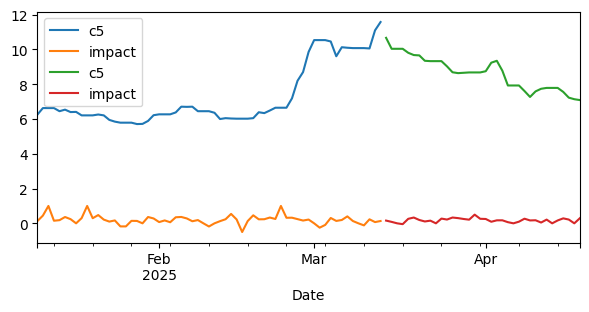

In [610]:
train_start = training.date.min()
train_end = training.date.max() - pd.Timedelta(days=36)

test_start = training.date.max() - pd.Timedelta(days=35)
test_end = training.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]

fig, ax = plt.subplots(figsize=(7, 3))
train.plot(ax=ax, label = "Train")
test.plot(ax=ax, label = "Test")
ax.legend()

In [612]:
window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

In [613]:
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

## Runs

In [614]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.148036  0.638326
1                      Ridge  Default        None  0.201714  0.507182
4                        SVR  Default        None  0.246281  0.398301
3                 ElasticNet  Default        None  0.427000 -0.043223
2                      Lasso  Default        None  0.445943 -0.089504
5      RandomForestRegressor  Default        None  1.183560 -1.891608
6  GradientBoostingRegressor  Default        None  1.239943 -2.029359
7               XGBRegressor  Default        None  1.310203 -2.201014
8              LGBMRegressor  Default        None  1.584902 -2.872146


In [615]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.147009  0.640837
1                      Ridge  Default        None  0.200944  0.509065
4                        SVR  Default        None  0.282239  0.310450
3                 ElasticNet  Default        None  0.427000 -0.043223
2                      Lasso  Default        None  0.445943 -0.089504
7               XGBRegressor  Default        None  1.098954 -1.684904
5      RandomForestRegressor  Default        None  1.337097 -2.266721
8              LGBMRegressor  Default        None  1.363397 -2.330977
6  GradientBoostingRegressor  Default        None  1.578849 -2.857356


In [616]:
import statsmodels.api as sm

# Example for X_train_impact and y_train
X_sm = sm.add_constant(X_train)  # Adds intercept term
model = sm.OLS(y_train, X_sm)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     115.6
Date:                Tue, 27 May 2025   Prob (F-statistic):           8.87e-37
Time:                        08:25:32   Log-Likelihood:                -31.326
No. Observations:                  73   AIC:                             88.65
Df Residuals:                      60   BIC:                             118.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0813      0.265      0.306      0.7

## Diagnostics

In [621]:
data = c5_w_df[['c5', 'impact']].dropna()
grangercausalitytests(data[['c5', 'impact']], maxlag=8, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2582  , p=0.6125  , df_denom=95, df_num=1
ssr based chi2 test:   chi2=0.2664  , p=0.6058  , df=1
likelihood ratio test: chi2=0.2660  , p=0.6060  , df=1
parameter F test:         F=0.2582  , p=0.6125  , df_denom=95, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6024  , p=0.5496  , df_denom=92, df_num=2
ssr based chi2 test:   chi2=1.2703  , p=0.5298  , df=2
likelihood ratio test: chi2=1.2621  , p=0.5320  , df=2
parameter F test:         F=0.6024  , p=0.5496  , df_denom=92, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7064  , p=0.5507  , df_denom=89, df_num=3
ssr based chi2 test:   chi2=2.2858  , p=0.5152  , df=3
likelihood ratio test: chi2=2.2590  , p=0.5204  , df=3
parameter F test:         F=0.7064  , p=0.5507  , df_denom=89, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4813  , p=0.7494  , df_d

{np.int64(1): ({'ssr_ftest': (np.float64(0.25821894018281455),
    np.float64(0.6125243363028199),
    np.float64(95.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.26637322250437706),
    np.float64(0.6057750871407086),
    np.int64(1)),
   'lrtest': (np.float64(0.266011863418413),
    np.float64(0.6060196824679894),
    np.int64(1)),
   'params_ftest': (np.float64(0.2582189401827622),
    np.float64(0.6125243363028563),
    np.float64(95.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.6024260711484367),
    np.float64(0.5496269929891429),
    np.float64(92.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(1.270333236986921),
    np.float64(0.5298471986204264),
    np.int64(2)),
   'lrtest': (np.float64(1.2620868752974843),
    np.float64(0.5320363645023902),
    np.int64(2)),
   'params_ftest': (np.float64(0.6024260711484484),
    np.float64(0.5496269929891344),
    np.float64(92.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
          

## Correlation

In [622]:
corr = c5_w_df['c5'].corr(c5_w_df['impact'])
print(f"Correlation between c5 and impact: {corr:.3f}")

Correlation between c5 and impact: -0.169
